In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.list_physical_devices(device_type=None)

import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import h5py
from sklearn.utils import shuffle


from tensorflow.keras.layers import MultiHeadAttention,Bidirectional,GlobalAveragePooling1D,GlobalMaxPooling1D,concatenate
from tensorflow.keras import callbacks 

from sklearn.model_selection import KFold

In [2]:
#retrieve data
num = 4000 # number of profiles
nvza = 12 # number of channels
nsza=6



In [3]:
s = 82 # output slice size
ts = 82 # input slice size 32


In [4]:
#get the averaged reflectance from the dataset 
r=np.load('all_angles_r.npy')
c=np.load('cot_500m.npy')


In [5]:
r.shape

(4000, 82, 6, 12)

In [6]:
r=r.reshape((4000,82,72))

In [7]:
r,c= shuffle(r, c, random_state=0)#Shuffle arrays in a consistent way.

#train test split
trp = 0.8; # 80 percent to train, includes validation
train_size=int(trp*num)
test_size = num - train_size #20% for testing:0.20*4000=800

print("train_size:",train_size,'profiles')
print("test_size:",test_size,'profiles')


train_size: 3200 profiles
test_size: 800 profiles


In [18]:
import os
checkpoint_path = "training_transformer/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [19]:

def eval_model(train_image, test_image, train_label, test_label):

    ltype = 'mean_squared_error'
    type2=tf.keras.metrics.RootMeanSquaredError()
    bsize = 16
    eps = 4000

    #bi-LSTM
    input_layer = tf.keras.layers.Input(shape=(ts,72),name='Input')
    bi=Bidirectional(tf.keras.layers.LSTM(units=64, activation='tanh',return_sequences = True,
                                          input_shape=(ts,72)))(input_layer) 
    bi=Bidirectional(tf.keras.layers.LSTM(units=64, activation='tanh',return_sequences = True))(bi)


    #transformer block 
    slf_attn = MultiHeadAttention(num_heads=3,key_dim=3)(bi,bi) 
    layernorm1=tf.keras.layers.LayerNormalization(epsilon=1e-6)(slf_attn+bi)
    dense1=tf.keras.layers.Dense(128,activation='relu')(layernorm1)
    layernorm2=tf.keras.layers.LayerNormalization(epsilon=1e-6)(layernorm1+dense1)
    
    flat=tf.keras.layers.Flatten()(layernorm2)
    #pooling
    #avg_pool = GlobalAveragePooling1D()(layernorm2)
    #max_pool = GlobalMaxPooling1D()(layernorm2)
    #conc = concatenate([avg_pool, max_pool])

    #dense
   # dense2 = tf.keras.layers.Dense(256,activation='relu')(conc)
    drop=tf.keras.layers.Dropout(0.2)(flat)
    output = tf.keras.layers.Dense(82,activation='relu')(drop)

    model = tf.keras.models.Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='adam',loss=['mse'],metrics=[ltype,type2])
    model.summary()

    #earlystopping to find the optimal number of epochs 
    earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                                mode ="min", patience = 25,  
                                                restore_best_weights = True,
                                               verbose=1) 
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,save_freq=5*bsize)
    # Save the weights using the `checkpoint_path` format
    model.save_weights(checkpoint_path.format(epoch=0))

    history = model.fit(train_image,train_label,batch_size = bsize,epochs = eps,validation_split=0.25,
                              callbacks =[earlystopping,cp_callback])

    # test and predict ---------------------------------------------------------------------------------------

    print('test result')
    results = model.evaluate(test_image, test_label)
    results
    predictions=model.predict(test_image)

    mse = results[1]
    rmse = results[2]
    
    return model,rmse,mse,history,predictions

In [20]:
n_folds=5

kf = KFold(n_splits=n_folds,random_state=None, shuffle=False)
print(kf.get_n_splits(r))
print(kf)
ratio=int(r.shape[0]/n_folds)

X_train=np.zeros((5,800*4,ts,72)) #train: 800*4  test:800
y_train=np.zeros((5,ratio*(n_folds-1),82))
X_test=np.zeros((n_folds,ratio,ts,72))
y_test=np.zeros((n_folds,ratio,82))

count=0
for train_index, test_index in kf.split(r):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train[count], X_test[count] = r[train_index], r[test_index] #r: radiance dataset
    y_train[count], y_test[count] = c[train_index], c[test_index] #c: cot dataset(label)
    count+=1

5
KFold(n_splits=5, random_state=None, shuffle=False)
TRAIN: [ 800  801  802 ... 3997 3998 3999] TEST: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 

TRAIN: [   0    1    2 ... 3997 3998 3999] TEST: [2400 2401 2402 2403 2404 2405 2406 2407 2408 2409 2410 2411 2412 2413
 2414 2415 2416 2417 2418 2419 2420 2421 2422 2423 2424 2425 2426 2427
 2428 2429 2430 2431 2432 2433 2434 2435 2436 2437 2438 2439 2440 2441
 2442 2443 2444 2445 2446 2447 2448 2449 2450 2451 2452 2453 2454 2455
 2456 2457 2458 2459 2460 2461 2462 2463 2464 2465 2466 2467 2468 2469
 2470 2471 2472 2473 2474 2475 2476 2477 2478 2479 2480 2481 2482 2483
 2484 2485 2486 2487 2488 2489 2490 2491 2492 2493 2494 2495 2496 2497
 2498 2499 2500 2501 2502 2503 2504 2505 2506 2507 2508 2509 2510 2511
 2512 2513 2514 2515 2516 2517 2518 2519 2520 2521 2522 2523 2524 2525
 2526 2527 2528 2529 2530 2531 2532 2533 2534 2535 2536 2537 2538 2539
 2540 2541 2542 2543 2544 2545 2546 2547 2548 2549 2550 2551 2552 2553
 2554 2555 2556 2557 2558 2559 2560 2561 2562 2563 2564 2565 2566 2567
 2568 2569 2570 2571 2572 2573 2574 2575 2576 2577 2578 2579 2580 2581
 2582 2583 2584 2585 2586 25

In [21]:
# evaluate model----------------------------------------------------------------------------------------------
cv_scores = list()
cv_scores2 = list()

for n in range(n_folds):
        # split data    
    train_image, test_image, train_label, test_label = X_train[n],X_test[n],y_train[n],y_test[n]
        # evaluate model
    model,rmse,mse,history,predictions= eval_model(train_image, test_image, train_label, test_label)
    print('MSE on test set in fold'+str(n+1)+' : '+str(mse))
    print('RMSE on test set in fold'+str(n+1)+' : '+str(rmse))

    cv_scores.append(mse)
    cv_scores2.append(rmse)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 82, 72)]     0                                            
__________________________________________________________________________________________________
bidirectional_6 (Bidirectional) (None, 82, 128)      70144       Input[0][0]                      
__________________________________________________________________________________________________
bidirectional_7 (Bidirectional) (None, 82, 128)      98816       bidirectional_6[0][0]            
__________________________________________________________________________________________________
multi_head_attention_3 (MultiHe (None, 82, 128)      4763        bidirectional_7[0][0]            
                                                                 bidirectional_7[0][0]      

150/150 [==============================] - 4s 25ms/step - loss: 0.8635 - mean_squared_error: 0.8635 - root_mean_squared_error: 0.9292 - val_loss: 0.4736 - val_mean_squared_error: 0.4736 - val_root_mean_squared_error: 0.6882
Epoch 10/4000
  9/150 [>.............................] - ETA: 3s - loss: 0.7775 - mean_squared_error: 0.7775 - root_mean_squared_error: 0.8814
Epoch 00010: saving model to training_transformer\cp-0010.ckpt
 89/150 [================>.............] - ETA: 1s - loss: 0.8253 - mean_squared_error: 0.8253 - root_mean_squared_error: 0.9084
Epoch 00010: saving model to training_transformer\cp-0010.ckpt
150/150 [==============================] - 4s 27ms/step - loss: 0.8232 - mean_squared_error: 0.8232 - root_mean_squared_error: 0.9072 - val_loss: 0.4301 - val_mean_squared_error: 0.4301 - val_root_mean_squared_error: 0.6559
Epoch 11/4000
 19/150 [==>...........................] - ETA: 2s - loss: 0.7150 - mean_squared_error: 0.7150 - root_mean_squared_error: 0.8455
Epoch 00011

 58/150 [==========>...................] - ETA: 2s - loss: 0.4442 - mean_squared_error: 0.4442 - root_mean_squared_error: 0.6664
Epoch 00023: saving model to training_transformer\cp-0023.ckpt
140/150 [===========================>..] - ETA: 0s - loss: 0.4408 - mean_squared_error: 0.4408 - root_mean_squared_error: 0.6639
Epoch 00023: saving model to training_transformer\cp-0023.ckpt
150/150 [==============================] - 4s 28ms/step - loss: 0.4409 - mean_squared_error: 0.4409 - root_mean_squared_error: 0.6640 - val_loss: 0.2800 - val_mean_squared_error: 0.2800 - val_root_mean_squared_error: 0.5291
Epoch 24/4000
 68/150 [============>.................] - ETA: 1s - loss: 0.4663 - mean_squared_error: 0.4663 - root_mean_squared_error: 0.6828
Epoch 00024: saving model to training_transformer\cp-0024.ckpt
150/150 [==============================] - ETA: 0s - loss: 0.4611 - mean_squared_error: 0.4611 - root_mean_squared_error: 0.6790
Epoch 00024: saving model to training_transformer\cp-0024

150/150 [==============================] - 4s 28ms/step - loss: 0.3808 - mean_squared_error: 0.3808 - root_mean_squared_error: 0.6171 - val_loss: 0.1711 - val_mean_squared_error: 0.1711 - val_root_mean_squared_error: 0.4136
Epoch 37/4000
 40/150 [=======>......................] - ETA: 2s - loss: 0.3411 - mean_squared_error: 0.3411 - root_mean_squared_error: 0.5840
Epoch 00037: saving model to training_transformer\cp-0037.ckpt
119/150 [======================>.......] - ETA: 0s - loss: 0.3465 - mean_squared_error: 0.3465 - root_mean_squared_error: 0.5886
Epoch 00037: saving model to training_transformer\cp-0037.ckpt
150/150 [==============================] - 4s 26ms/step - loss: 0.3468 - mean_squared_error: 0.3468 - root_mean_squared_error: 0.5889 - val_loss: 0.3092 - val_mean_squared_error: 0.3092 - val_root_mean_squared_error: 0.5561
Epoch 38/4000
 49/150 [========>.....................] - ETA: 2s - loss: 0.4080 - mean_squared_error: 0.4080 - root_mean_squared_error: 0.6386
Epoch 00038

 90/150 [=================>............] - ETA: 1s - loss: 0.3181 - mean_squared_error: 0.3181 - root_mean_squared_error: 0.5639
Epoch 00050: saving model to training_transformer\cp-0050.ckpt
150/150 [==============================] - 4s 28ms/step - loss: 0.3202 - mean_squared_error: 0.3202 - root_mean_squared_error: 0.5658 - val_loss: 0.1632 - val_mean_squared_error: 0.1632 - val_root_mean_squared_error: 0.4039
Epoch 51/4000
 19/150 [==>...........................] - ETA: 2s - loss: 0.3230 - mean_squared_error: 0.3230 - root_mean_squared_error: 0.5682
Epoch 00051: saving model to training_transformer\cp-0051.ckpt
100/150 [===================>..........] - ETA: 1s - loss: 0.3217 - mean_squared_error: 0.3217 - root_mean_squared_error: 0.5671
Epoch 00051: saving model to training_transformer\cp-0051.ckpt
150/150 [==============================] - 4s 26ms/step - loss: 0.3190 - mean_squared_error: 0.3190 - root_mean_squared_error: 0.5648 - val_loss: 0.1838 - val_mean_squared_error: 0.1838 

150/150 [==============================] - 4s 27ms/step - loss: 0.2950 - mean_squared_error: 0.2950 - root_mean_squared_error: 0.5431 - val_loss: 0.1373 - val_mean_squared_error: 0.1373 - val_root_mean_squared_error: 0.3706
Epoch 64/4000
 70/150 [=============>................] - ETA: 1s - loss: 0.2824 - mean_squared_error: 0.2824 - root_mean_squared_error: 0.5314
Epoch 00064: saving model to training_transformer\cp-0064.ckpt
149/150 [============================>.] - ETA: 0s - loss: 0.2893 - mean_squared_error: 0.2893 - root_mean_squared_error: 0.5378
Epoch 00064: saving model to training_transformer\cp-0064.ckpt
150/150 [==============================] - 4s 25ms/step - loss: 0.2895 - mean_squared_error: 0.2895 - root_mean_squared_error: 0.5380 - val_loss: 0.1836 - val_mean_squared_error: 0.1836 - val_root_mean_squared_error: 0.4285
Epoch 65/4000
 79/150 [==============>...............] - ETA: 1s - loss: 0.3017 - mean_squared_error: 0.3017 - root_mean_squared_error: 0.5491
Epoch 00065

 39/150 [======>.......................] - ETA: 2s - loss: 0.2690 - mean_squared_error: 0.2690 - root_mean_squared_error: 0.5186
Epoch 00077: saving model to training_transformer\cp-0077.ckpt
119/150 [======================>.......] - ETA: 0s - loss: 0.2684 - mean_squared_error: 0.2684 - root_mean_squared_error: 0.5181
Epoch 00077: saving model to training_transformer\cp-0077.ckpt
150/150 [==============================] - 4s 28ms/step - loss: 0.2687 - mean_squared_error: 0.2687 - root_mean_squared_error: 0.5183 - val_loss: 0.1197 - val_mean_squared_error: 0.1197 - val_root_mean_squared_error: 0.3459
Epoch 78/4000
 49/150 [========>.....................] - ETA: 2s - loss: 0.2674 - mean_squared_error: 0.2674 - root_mean_squared_error: 0.5171
Epoch 00078: saving model to training_transformer\cp-0078.ckpt
129/150 [========================>.....] - ETA: 0s - loss: 0.2718 - mean_squared_error: 0.2718 - root_mean_squared_error: 0.5213
Epoch 00078: saving model to training_transformer\cp-0078

150/150 [==============================] - 4s 28ms/step - loss: 0.2683 - mean_squared_error: 0.2683 - root_mean_squared_error: 0.5179 - val_loss: 0.1464 - val_mean_squared_error: 0.1464 - val_root_mean_squared_error: 0.3826
Epoch 91/4000
 18/150 [==>...........................] - ETA: 2s - loss: 0.2548 - mean_squared_error: 0.2548 - root_mean_squared_error: 0.5047
Epoch 00091: saving model to training_transformer\cp-0091.ckpt
 99/150 [==================>...........] - ETA: 1s - loss: 0.2557 - mean_squared_error: 0.2557 - root_mean_squared_error: 0.5057
Epoch 00091: saving model to training_transformer\cp-0091.ckpt
150/150 [==============================] - 4s 28ms/step - loss: 0.2542 - mean_squared_error: 0.2542 - root_mean_squared_error: 0.5042 - val_loss: 0.1118 - val_mean_squared_error: 0.1118 - val_root_mean_squared_error: 0.3344
Epoch 92/4000
 28/150 [====>.........................] - ETA: 2s - loss: 0.2488 - mean_squared_error: 0.2488 - root_mean_squared_error: 0.4987
Epoch 00092

 69/150 [============>.................] - ETA: 1s - loss: 0.2692 - mean_squared_error: 0.2692 - root_mean_squared_error: 0.5188
Epoch 00104: saving model to training_transformer\cp-0104.ckpt
148/150 [============================>.] - ETA: 0s - loss: 0.2605 - mean_squared_error: 0.2605 - root_mean_squared_error: 0.5103
Epoch 00104: saving model to training_transformer\cp-0104.ckpt
150/150 [==============================] - 4s 29ms/step - loss: 0.2603 - mean_squared_error: 0.2603 - root_mean_squared_error: 0.5101 - val_loss: 0.0940 - val_mean_squared_error: 0.0940 - val_root_mean_squared_error: 0.3065
Epoch 105/4000
 79/150 [==============>...............] - ETA: 1s - loss: 0.2443 - mean_squared_error: 0.2443 - root_mean_squared_error: 0.4943 ETA: 2s - loss: 0.2493 - mean_squared_error: 0.2493 - root_mean_squared_error: 0.49 - ETA: 2s - loss: 0.2492 - mean_squared_error: 0.2492 -
Epoch 00105: saving model to training_transformer\cp-0105.ckpt
150/150 [==============================] - 4s

119/150 [======================>.......] - ETA: 0s - loss: 0.2378 - mean_squared_error: 0.2378 - root_mean_squared_error: 0.4876
Epoch 00117: saving model to training_transformer\cp-0117.ckpt
150/150 [==============================] - 4s 25ms/step - loss: 0.2366 - mean_squared_error: 0.2366 - root_mean_squared_error: 0.4864 - val_loss: 0.1368 - val_mean_squared_error: 0.1368 - val_root_mean_squared_error: 0.3698
Epoch 118/4000
 49/150 [========>.....................] - ETA: 2s - loss: 0.2332 - mean_squared_error: 0.2332 - root_mean_squared_error: 0.4828
Epoch 00118: saving model to training_transformer\cp-0118.ckpt
128/150 [========================>.....] - ETA: 0s - loss: 0.2344 - mean_squared_error: 0.2344 - root_mean_squared_error: 0.4841
Epoch 00118: saving model to training_transformer\cp-0118.ckpt
150/150 [==============================] - 4s 25ms/step - loss: 0.2350 - mean_squared_error: 0.2350 - root_mean_squared_error: 0.4848 - val_loss: 0.1458 - val_mean_squared_error: 0.1458

 90/150 [=================>............] - ETA: 1s - loss: 0.2313 - mean_squared_error: 0.2313 - root_mean_squared_error: 0.4809 ETA: 2s - loss: 0.2333 - mean_squared_error: 0.2333 - roo
Epoch 00130: saving model to training_transformer\cp-0130.ckpt
150/150 [==============================] - 4s 29ms/step - loss: 0.2299 - mean_squared_error: 0.2299 - root_mean_squared_error: 0.4794 - val_loss: 0.0824 - val_mean_squared_error: 0.0824 - val_root_mean_squared_error: 0.2870
Epoch 131/4000
 20/150 [===>..........................] - ETA: 2s - loss: 0.2110 - mean_squared_error: 0.2110 - root_mean_squared_error: 0.4593
Epoch 00131: saving model to training_transformer\cp-0131.ckpt
 98/150 [==================>...........] - ETA: 1s - loss: 0.2221 - mean_squared_error: 0.2221 - root_mean_squared_error: 0.4712
Epoch 00131: saving model to training_transformer\cp-0131.ckpt
150/150 [==============================] - 4s 27ms/step - loss: 0.2247 - mean_squared_error: 0.2247 - root_mean_squared_error: 

150/150 [==============================] - 4s 26ms/step - loss: 0.2152 - mean_squared_error: 0.2152 - root_mean_squared_error: 0.4639 - val_loss: 0.0749 - val_mean_squared_error: 0.0749 - val_root_mean_squared_error: 0.2737
Epoch 144/4000
 70/150 [=============>................] - ETA: 1s - loss: 0.2211 - mean_squared_error: 0.2211 - root_mean_squared_error: 0.4702
Epoch 00144: saving model to training_transformer\cp-0144.ckpt
150/150 [==============================] - ETA: 0s - loss: 0.2212 - mean_squared_error: 0.2212 - root_mean_squared_error: 0.4703
Epoch 00144: saving model to training_transformer\cp-0144.ckpt
150/150 [==============================] - 4s 28ms/step - loss: 0.2212 - mean_squared_error: 0.2212 - root_mean_squared_error: 0.4703 - val_loss: 0.1284 - val_mean_squared_error: 0.1284 - val_root_mean_squared_error: 0.3583
Epoch 145/4000
 79/150 [==============>...............] - ETA: 1s - loss: 0.2195 - mean_squared_error: 0.2195 - root_mean_squared_error: 0.4685
Epoch 001

119/150 [======================>.......] - ETA: 0s - loss: 0.2165 - mean_squared_error: 0.2165 - root_mean_squared_error: 0.4652
Epoch 00157: saving model to training_transformer\cp-0157.ckpt
150/150 [==============================] - 4s 25ms/step - loss: 0.2167 - mean_squared_error: 0.2167 - root_mean_squared_error: 0.4655 - val_loss: 0.0908 - val_mean_squared_error: 0.0908 - val_root_mean_squared_error: 0.3013
Epoch 158/4000
 48/150 [========>.....................] - ETA: 2s - loss: 0.2184 - mean_squared_error: 0.2184 - root_mean_squared_error: 0.4673
Epoch 00158: saving model to training_transformer\cp-0158.ckpt
128/150 [========================>.....] - ETA: 0s - loss: 0.2227 - mean_squared_error: 0.2227 - root_mean_squared_error: 0.4719
Epoch 00158: saving model to training_transformer\cp-0158.ckpt
150/150 [==============================] - 4s 27ms/step - loss: 0.2231 - mean_squared_error: 0.2231 - root_mean_squared_error: 0.4723 - val_loss: 0.0916 - val_mean_squared_error: 0.0916

 19/150 [==>...........................] - ETA: 2s - loss: 0.1980 - mean_squared_error: 0.1980 - root_mean_squared_error: 0.4450
Epoch 00171: saving model to training_transformer\cp-0171.ckpt
 99/150 [==================>...........] - ETA: 1s - loss: 0.2097 - mean_squared_error: 0.2097 - root_mean_squared_error: 0.4579
Epoch 00171: saving model to training_transformer\cp-0171.ckpt
150/150 [==============================] - 4s 25ms/step - loss: 0.2101 - mean_squared_error: 0.2101 - root_mean_squared_error: 0.4583 - val_loss: 0.0987 - val_mean_squared_error: 0.0987 - val_root_mean_squared_error: 0.3142
Epoch 172/4000
 29/150 [====>.........................] - ETA: 2s - loss: 0.2142 - mean_squared_error: 0.2142 - root_mean_squared_error: 0.4627
Epoch 00172: saving model to training_transformer\cp-0172.ckpt
110/150 [=====================>........] - ETA: 0s - loss: 0.2091 - mean_squared_error: 0.2091 - root_mean_squared_error: 0.4572
Epoch 00172: saving model to training_transformer\cp-017

148/150 [============================>.] - ETA: 0s - loss: 0.2024 - mean_squared_error: 0.2024 - root_mean_squared_error: 0.4499
Epoch 00184: saving model to training_transformer\cp-0184.ckpt
150/150 [==============================] - 4s 27ms/step - loss: 0.2025 - mean_squared_error: 0.2025 - root_mean_squared_error: 0.4500 - val_loss: 0.0879 - val_mean_squared_error: 0.0879 - val_root_mean_squared_error: 0.2965
Epoch 185/4000
 80/150 [===============>..............] - ETA: 1s - loss: 0.2149 - mean_squared_error: 0.2149 - root_mean_squared_error: 0.4635 ETA: 1s - loss: 0.2153 - mean_squared_error: 0.2153 - root_mean_squared_error: 0.
Epoch 00185: saving model to training_transformer\cp-0185.ckpt
150/150 [==============================] - 4s 28ms/step - loss: 0.2123 - mean_squared_error: 0.2123 - root_mean_squared_error: 0.4607 - val_loss: 0.0695 - val_mean_squared_error: 0.0695 - val_root_mean_squared_error: 0.2637
Epoch 186/4000
 10/150 [=>............................] - ETA: 3s - los

100/150 [===================>..........] - ETA: 1s - loss: 4.3829 - mean_squared_error: 4.3829 - root_mean_squared_error: 2.0929
Epoch 00003: saving model to training_transformer\cp-0003.ckpt
150/150 [==============================] - 4s 28ms/step - loss: 4.2005 - mean_squared_error: 4.2005 - root_mean_squared_error: 2.0481 - val_loss: 2.1705 - val_mean_squared_error: 2.1705 - val_root_mean_squared_error: 1.4733
Epoch 4/4000
 28/150 [====>.........................] - ETA: 2s - loss: 2.5457 - mean_squared_error: 2.5457 - root_mean_squared_error: 1.5953
Epoch 00004: saving model to training_transformer\cp-0004.ckpt
109/150 [====================>.........] - ETA: 0s - loss: 2.3998 - mean_squared_error: 2.3998 - root_mean_squared_error: 1.5487
Epoch 00004: saving model to training_transformer\cp-0004.ckpt
150/150 [==============================] - 4s 26ms/step - loss: 2.3369 - mean_squared_error: 2.3369 - root_mean_squared_error: 1.5280 - val_loss: 1.2402 - val_mean_squared_error: 1.2402 -

Epoch 17/4000
 80/150 [===============>..............] - ETA: 1s - loss: 0.5567 - mean_squared_error: 0.5567 - root_mean_squared_error: 0.7459
Epoch 00017: saving model to training_transformer\cp-0017.ckpt
150/150 [==============================] - 4s 28ms/step - loss: 0.5528 - mean_squared_error: 0.5528 - root_mean_squared_error: 0.7434 - val_loss: 0.2690 - val_mean_squared_error: 0.2690 - val_root_mean_squared_error: 0.5186
Epoch 18/4000
 10/150 [=>............................] - ETA: 2s - loss: 0.5433 - mean_squared_error: 0.5433 - root_mean_squared_error: 0.7371
Epoch 00018: saving model to training_transformer\cp-0018.ckpt
 89/150 [================>.............] - ETA: 1s - loss: 0.5209 - mean_squared_error: 0.5209 - root_mean_squared_error: 0.7217
Epoch 00018: saving model to training_transformer\cp-0018.ckpt
150/150 [==============================] - 4s 25ms/step - loss: 0.5159 - mean_squared_error: 0.5159 - root_mean_squared_error: 0.7182 - val_loss: 0.2623 - val_mean_squared_

150/150 [==============================] - 4s 28ms/step - loss: 0.3884 - mean_squared_error: 0.3884 - root_mean_squared_error: 0.6232 - val_loss: 0.1893 - val_mean_squared_error: 0.1893 - val_root_mean_squared_error: 0.4351
Epoch 31/4000
 58/150 [==========>...................] - ETA: 1s - loss: 0.3611 - mean_squared_error: 0.3611 - root_mean_squared_error: 0.6008
Epoch 00031: saving model to training_transformer\cp-0031.ckpt
139/150 [==========================>...] - ETA: 0s - loss: 0.3624 - mean_squared_error: 0.3624 - root_mean_squared_error: 0.6020
Epoch 00031: saving model to training_transformer\cp-0031.ckpt
150/150 [==============================] - 4s 25ms/step - loss: 0.3628 - mean_squared_error: 0.3628 - root_mean_squared_error: 0.6023 - val_loss: 0.2086 - val_mean_squared_error: 0.2086 - val_root_mean_squared_error: 0.4567
Epoch 32/4000
 68/150 [============>.................] - ETA: 1s - loss: 0.3720 - mean_squared_error: 0.3720 - root_mean_squared_error: 0.6099
Epoch 00032

109/150 [====================>.........] - ETA: 0s - loss: 0.3251 - mean_squared_error: 0.3251 - root_mean_squared_error: 0.5700
Epoch 00044: saving model to training_transformer\cp-0044.ckpt
150/150 [==============================] - 4s 26ms/step - loss: 0.3279 - mean_squared_error: 0.3279 - root_mean_squared_error: 0.5725 - val_loss: 0.2089 - val_mean_squared_error: 0.2089 - val_root_mean_squared_error: 0.4571
Epoch 45/4000
 40/150 [=======>......................] - ETA: 2s - loss: 0.3432 - mean_squared_error: 0.3432 - root_mean_squared_error: 0.5858
Epoch 00045: saving model to training_transformer\cp-0045.ckpt
120/150 [=======================>......] - ETA: 0s - loss: 0.3429 - mean_squared_error: 0.3429 - root_mean_squared_error: 0.5856
Epoch 00045: saving model to training_transformer\cp-0045.ckpt
150/150 [==============================] - 4s 29ms/step - loss: 0.3414 - mean_squared_error: 0.3414 - root_mean_squared_error: 0.5842 - val_loss: 0.1846 - val_mean_squared_error: 0.1846 

  9/150 [>.............................] - ETA: 3s - loss: 0.3060 - mean_squared_error: 0.3060 - root_mean_squared_error: 0.5531
Epoch 00058: saving model to training_transformer\cp-0058.ckpt
 88/150 [================>.............] - ETA: 1s - loss: 0.3108 - mean_squared_error: 0.3108 - root_mean_squared_error: 0.5573
Epoch 00058: saving model to training_transformer\cp-0058.ckpt
150/150 [==============================] - 4s 29ms/step - loss: 0.3063 - mean_squared_error: 0.3063 - root_mean_squared_error: 0.5533 - val_loss: 0.1260 - val_mean_squared_error: 0.1260 - val_root_mean_squared_error: 0.3549
Epoch 59/4000
 20/150 [===>..........................] - ETA: 3s - loss: 0.2996 - mean_squared_error: 0.2996 - root_mean_squared_error: 0.5473
Epoch 00059: saving model to training_transformer\cp-0059.ckpt
 99/150 [==================>...........] - ETA: 1s - loss: 0.2906 - mean_squared_error: 0.2906 - root_mean_squared_error: 0.5390
Epoch 00059: saving model to training_transformer\cp-0059

138/150 [==========================>...] - ETA: 0s - loss: 0.2772 - mean_squared_error: 0.2772 - root_mean_squared_error: 0.5264
Epoch 00071: saving model to training_transformer\cp-0071.ckpt
150/150 [==============================] - 4s 29ms/step - loss: 0.2774 - mean_squared_error: 0.2774 - root_mean_squared_error: 0.5267 - val_loss: 0.1276 - val_mean_squared_error: 0.1276 - val_root_mean_squared_error: 0.3572
Epoch 72/4000
 69/150 [============>.................] - ETA: 1s - loss: 0.2808 - mean_squared_error: 0.2808 - root_mean_squared_error: 0.5299
Epoch 00072: saving model to training_transformer\cp-0072.ckpt
148/150 [============================>.] - ETA: 0s - loss: 0.2791 - mean_squared_error: 0.2791 - root_mean_squared_error: 0.5282
Epoch 00072: saving model to training_transformer\cp-0072.ckpt
150/150 [==============================] - 4s 28ms/step - loss: 0.2790 - mean_squared_error: 0.2790 - root_mean_squared_error: 0.5282 - val_loss: 0.1418 - val_mean_squared_error: 0.1418 

 40/150 [=======>......................] - ETA: 2s - loss: 0.2665 - mean_squared_error: 0.2665 - root_mean_squared_error: 0.5162
Epoch 00085: saving model to training_transformer\cp-0085.ckpt
120/150 [=======================>......] - ETA: 0s - loss: 0.2634 - mean_squared_error: 0.2634 - root_mean_squared_error: 0.5133
Epoch 00085: saving model to training_transformer\cp-0085.ckpt
150/150 [==============================] - 4s 26ms/step - loss: 0.2627 - mean_squared_error: 0.2627 - root_mean_squared_error: 0.5126 - val_loss: 0.1139 - val_mean_squared_error: 0.1139 - val_root_mean_squared_error: 0.3374
Epoch 86/4000
 49/150 [========>.....................] - ETA: 2s - loss: 0.2502 - mean_squared_error: 0.2502 - root_mean_squared_error: 0.5001
Epoch 00086: saving model to training_transformer\cp-0086.ckpt
129/150 [========================>.....] - ETA: 0s - loss: 0.2487 - mean_squared_error: 0.2487 - root_mean_squared_error: 0.4986
Epoch 00086: saving model to training_transformer\cp-0086

150/150 [==============================] - 4s 26ms/step - loss: 0.2376 - mean_squared_error: 0.2376 - root_mean_squared_error: 0.4874 - val_loss: 0.0903 - val_mean_squared_error: 0.0903 - val_root_mean_squared_error: 0.3005
Epoch 99/4000
 18/150 [==>...........................] - ETA: 3s - loss: 0.2331 - mean_squared_error: 0.2331 - root_mean_squared_error: 0.4827
Epoch 00099: saving model to training_transformer\cp-0099.ckpt
 98/150 [==================>...........] - ETA: 1s - loss: 0.2439 - mean_squared_error: 0.2439 - root_mean_squared_error: 0.4938
Epoch 00099: saving model to training_transformer\cp-0099.ckpt
150/150 [==============================] - 4s 28ms/step - loss: 0.2436 - mean_squared_error: 0.2436 - root_mean_squared_error: 0.4936 - val_loss: 0.0903 - val_mean_squared_error: 0.0903 - val_root_mean_squared_error: 0.3005
Epoch 100/4000
 28/150 [====>.........................] - ETA: 2s - loss: 0.2433 - mean_squared_error: 0.2433 - root_mean_squared_error: 0.4932
Epoch 0010

Epoch 112/4000
 68/150 [============>.................] - ETA: 1s - loss: 0.2312 - mean_squared_error: 0.2312 - root_mean_squared_error: 0.4808
Epoch 00112: saving model to training_transformer\cp-0112.ckpt
148/150 [============================>.] - ETA: 0s - loss: 0.2366 - mean_squared_error: 0.2366 - root_mean_squared_error: 0.4864
Epoch 00112: saving model to training_transformer\cp-0112.ckpt
150/150 [==============================] - 4s 28ms/step - loss: 0.2367 - mean_squared_error: 0.2367 - root_mean_squared_error: 0.4865 - val_loss: 0.1189 - val_mean_squared_error: 0.1189 - val_root_mean_squared_error: 0.3448
Epoch 113/4000
 80/150 [===============>..............] - ETA: 1s - loss: 0.2502 - mean_squared_error: 0.2502 - root_mean_squared_error: 0.5002
Epoch 00113: saving model to training_transformer\cp-0113.ckpt
150/150 [==============================] - 4s 25ms/step - loss: 0.2455 - mean_squared_error: 0.2455 - root_mean_squared_error: 0.4954 - val_loss: 0.1074 - val_mean_square

150/150 [==============================] - 4s 28ms/step - loss: 0.2351 - mean_squared_error: 0.2351 - root_mean_squared_error: 0.4848 - val_loss: 0.0819 - val_mean_squared_error: 0.0819 - val_root_mean_squared_error: 0.2862
Epoch 126/4000
 49/150 [========>.....................] - ETA: 2s - loss: 0.2162 - mean_squared_error: 0.2162 - root_mean_squared_error: 0.4649
Epoch 00126: saving model to training_transformer\cp-0126.ckpt
129/150 [========================>.....] - ETA: 0s - loss: 0.2177 - mean_squared_error: 0.2177 - root_mean_squared_error: 0.4666
Epoch 00126: saving model to training_transformer\cp-0126.ckpt
150/150 [==============================] - 4s 26ms/step - loss: 0.2182 - mean_squared_error: 0.2182 - root_mean_squared_error: 0.4672 - val_loss: 0.0901 - val_mean_squared_error: 0.0901 - val_root_mean_squared_error: 0.3002
Epoch 127/4000
 60/150 [===========>..................] - ETA: 2s - loss: 0.2272 - mean_squared_error: 0.2272 - root_mean_squared_error: 0.4766
Epoch 001

 99/150 [==================>...........] - ETA: 1s - loss: 0.2198 - mean_squared_error: 0.2198 - root_mean_squared_error: 0.4688
Epoch 00139: saving model to training_transformer\cp-0139.ckpt
150/150 [==============================] - 4s 26ms/step - loss: 0.2213 - mean_squared_error: 0.2213 - root_mean_squared_error: 0.4704 - val_loss: 0.0811 - val_mean_squared_error: 0.0811 - val_root_mean_squared_error: 0.2848
Epoch 140/4000
 29/150 [====>.........................] - ETA: 2s - loss: 0.2181 - mean_squared_error: 0.2181 - root_mean_squared_error: 0.4670
Epoch 00140: saving model to training_transformer\cp-0140.ckpt
109/150 [====================>.........] - ETA: 1s - loss: 0.2185 - mean_squared_error: 0.2185 - root_mean_squared_error: 0.4674
Epoch 00140: saving model to training_transformer\cp-0140.ckpt
150/150 [==============================] - 4s 29ms/step - loss: 0.2198 - mean_squared_error: 0.2198 - root_mean_squared_error: 0.4688 - val_loss: 0.0911 - val_mean_squared_error: 0.0911

Epoch 153/4000
 80/150 [===============>..............] - ETA: 1s - loss: 0.2149 - mean_squared_error: 0.2149 - root_mean_squared_error: 0.4635
Epoch 00153: saving model to training_transformer\cp-0153.ckpt
150/150 [==============================] - 4s 25ms/step - loss: 0.2168 - mean_squared_error: 0.2168 - root_mean_squared_error: 0.4656 - val_loss: 0.0713 - val_mean_squared_error: 0.0713 - val_root_mean_squared_error: 0.2671
Epoch 154/4000
 10/150 [=>............................] - ETA: 2s - loss: 0.2064 - mean_squared_error: 0.2064 - root_mean_squared_error: 0.4541
Epoch 00154: saving model to training_transformer\cp-0154.ckpt
 89/150 [================>.............] - ETA: 1s - loss: 0.2309 - mean_squared_error: 0.2309 - root_mean_squared_error: 0.4803
Epoch 00154: saving model to training_transformer\cp-0154.ckpt
150/150 [==============================] - 4s 25ms/step - loss: 0.2319 - mean_squared_error: 0.2319 - root_mean_squared_error: 0.4815 - val_loss: 0.0867 - val_mean_square

Epoch 00166: saving model to training_transformer\cp-0166.ckpt
150/150 [==============================] - 4s 28ms/step - loss: 0.2135 - mean_squared_error: 0.2135 - root_mean_squared_error: 0.4621 - val_loss: 0.0834 - val_mean_squared_error: 0.0834 - val_root_mean_squared_error: 0.2889
Epoch 167/4000
 59/150 [==========>...................] - ETA: 2s - loss: 0.2063 - mean_squared_error: 0.2063 - root_mean_squared_error: 0.4542
Epoch 00167: saving model to training_transformer\cp-0167.ckpt
138/150 [==========================>...] - ETA: 0s - loss: 0.2062 - mean_squared_error: 0.2062 - root_mean_squared_error: 0.4541
Epoch 00167: saving model to training_transformer\cp-0167.ckpt
150/150 [==============================] - 4s 29ms/step - loss: 0.2062 - mean_squared_error: 0.2062 - root_mean_squared_error: 0.4541 - val_loss: 0.0768 - val_mean_squared_error: 0.0768 - val_root_mean_squared_error: 0.2771
Epoch 168/4000
 68/150 [============>.................] - ETA: 1s - loss: 0.2042 - mean_sq

Epoch 00180: saving model to training_transformer\cp-0180.ckpt
108/150 [====================>.........] - ETA: 0s - loss: 0.2167 - mean_squared_error: 0.2167 - root_mean_squared_error: 0.4655 ETA: 2s - loss: 0.2220 - mean_squared
Epoch 00180: saving model to training_transformer\cp-0180.ckpt
150/150 [==============================] - 4s 27ms/step - loss: 0.2167 - mean_squared_error: 0.2167 - root_mean_squared_error: 0.4655 - val_loss: 0.0847 - val_mean_squared_error: 0.0847 - val_root_mean_squared_error: 0.2910
Epoch 181/4000
 40/150 [=======>......................] - ETA: 2s - loss: 0.2026 - mean_squared_error: 0.2026 - root_mean_squared_error: 0.4500
Epoch 00181: saving model to training_transformer\cp-0181.ckpt
119/150 [======================>.......] - ETA: 0s - loss: 0.2051 - mean_squared_error: 0.2051 - root_mean_squared_error: 0.4529
Epoch 00181: saving model to training_transformer\cp-0181.ckpt
150/150 [==============================] - 4s 25ms/step - loss: 0.2053 - mean_square

150/150 [==============================] - 4s 27ms/step - loss: 0.2102 - mean_squared_error: 0.2102 - root_mean_squared_error: 0.4585 - val_loss: 0.0595 - val_mean_squared_error: 0.0595 - val_root_mean_squared_error: 0.2440
Epoch 194/4000
 10/150 [=>............................] - ETA: 2s - loss: 0.1881 - mean_squared_error: 0.1881 - root_mean_squared_error: 0.4337
Epoch 00194: saving model to training_transformer\cp-0194.ckpt
 90/150 [=================>............] - ETA: 1s - loss: 0.1928 - mean_squared_error: 0.1928 - root_mean_squared_error: 0.4391
Epoch 00194: saving model to training_transformer\cp-0194.ckpt
150/150 [==============================] - 4s 28ms/step - loss: 0.1954 - mean_squared_error: 0.1954 - root_mean_squared_error: 0.4420 - val_loss: 0.1343 - val_mean_squared_error: 0.1343 - val_root_mean_squared_error: 0.3665
Epoch 195/4000
 19/150 [==>...........................] - ETA: 2s - loss: 0.2332 - mean_squared_error: 0.2332 - root_mean_squared_error: 0.4826
Epoch 001

 60/150 [===========>..................] - ETA: 1s - loss: 0.1949 - mean_squared_error: 0.1949 - root_mean_squared_error: 0.4414
Epoch 00207: saving model to training_transformer\cp-0207.ckpt
139/150 [==========================>...] - ETA: 0s - loss: 0.1948 - mean_squared_error: 0.1948 - root_mean_squared_error: 0.4414
Epoch 00207: saving model to training_transformer\cp-0207.ckpt
150/150 [==============================] - 4s 26ms/step - loss: 0.1948 - mean_squared_error: 0.1948 - root_mean_squared_error: 0.4414 - val_loss: 0.0785 - val_mean_squared_error: 0.0785 - val_root_mean_squared_error: 0.2802
Epoch 208/4000
 68/150 [============>.................] - ETA: 1s - loss: 0.2177 - mean_squared_error: 0.2177 - root_mean_squared_error: 0.4665
Epoch 00208: saving model to training_transformer\cp-0208.ckpt
148/150 [============================>.] - ETA: 0s - loss: 0.2120 - mean_squared_error: 0.2120 - root_mean_squared_error: 0.4603
Epoch 00208: saving model to training_transformer\cp-020

150/150 [==============================] - 4s 28ms/step - loss: 0.1982 - mean_squared_error: 0.1982 - root_mean_squared_error: 0.4452 - val_loss: 0.0580 - val_mean_squared_error: 0.0580 - val_root_mean_squared_error: 0.2408
Epoch 221/4000
 39/150 [======>.......................] - ETA: 2s - loss: 0.1919 - mean_squared_error: 0.1919 - root_mean_squared_error: 0.4381
Epoch 00221: saving model to training_transformer\cp-0221.ckpt
118/150 [======================>.......] - ETA: 0s - loss: 0.1929 - mean_squared_error: 0.1929 - root_mean_squared_error: 0.4392
Epoch 00221: saving model to training_transformer\cp-0221.ckpt
150/150 [==============================] - 4s 29ms/step - loss: 0.1931 - mean_squared_error: 0.1931 - root_mean_squared_error: 0.4394 - val_loss: 0.0685 - val_mean_squared_error: 0.0685 - val_root_mean_squared_error: 0.2618
Epoch 222/4000
 50/150 [=========>....................] - ETA: 2s - loss: 0.1987 - mean_squared_error: 0.1987 - root_mean_squared_error: 0.4458
Epoch 002

 90/150 [=================>............] - ETA: 1s - loss: 0.2098 - mean_squared_error: 0.2098 - root_mean_squared_error: 0.4580
Epoch 00234: saving model to training_transformer\cp-0234.ckpt
150/150 [==============================] - 4s 28ms/step - loss: 0.2084 - mean_squared_error: 0.2084 - root_mean_squared_error: 0.4566 - val_loss: 0.0783 - val_mean_squared_error: 0.0783 - val_root_mean_squared_error: 0.2798
Epoch 235/4000
 19/150 [==>...........................] - ETA: 2s - loss: 0.1986 - mean_squared_error: 0.1986 - root_mean_squared_error: 0.4456
Epoch 00235: saving model to training_transformer\cp-0235.ckpt
 99/150 [==================>...........] - ETA: 1s - loss: 0.1975 - mean_squared_error: 0.1975 - root_mean_squared_error: 0.4444
Epoch 00235: saving model to training_transformer\cp-0235.ckpt
150/150 [==============================] - 4s 25ms/step - loss: 0.1969 - mean_squared_error: 0.1969 - root_mean_squared_error: 0.4437 - val_loss: 0.0621 - val_mean_squared_error: 0.0621

 59/150 [==========>...................] - ETA: 2s - loss: 1.0427 - mean_squared_error: 1.0427 - root_mean_squared_error: 1.0211
Epoch 00007: saving model to training_transformer\cp-0007.ckpt
138/150 [==========================>...] - ETA: 0s - loss: 1.0276 - mean_squared_error: 1.0276 - root_mean_squared_error: 1.0136
Epoch 00007: saving model to training_transformer\cp-0007.ckpt
150/150 [==============================] - 4s 28ms/step - loss: 1.0258 - mean_squared_error: 1.0258 - root_mean_squared_error: 1.0128 - val_loss: 0.6187 - val_mean_squared_error: 0.6187 - val_root_mean_squared_error: 0.7865
Epoch 8/4000
 70/150 [=============>................] - ETA: 1s - loss: 0.8870 - mean_squared_error: 0.8870 - root_mean_squared_error: 0.9418
Epoch 00008: saving model to training_transformer\cp-0008.ckpt
148/150 [============================>.] - ETA: 0s - loss: 0.8818 - mean_squared_error: 0.8818 - root_mean_squared_error: 0.9391
Epoch 00008: saving model to training_transformer\cp-0008.

150/150 [==============================] - 4s 26ms/step - loss: 0.4843 - mean_squared_error: 0.4843 - root_mean_squared_error: 0.6959 - val_loss: 0.2625 - val_mean_squared_error: 0.2625 - val_root_mean_squared_error: 0.5123
Epoch 21/4000
 40/150 [=======>......................] - ETA: 2s - loss: 0.4597 - mean_squared_error: 0.4597 - root_mean_squared_error: 0.6779
Epoch 00021: saving model to training_transformer\cp-0021.ckpt
118/150 [======================>.......] - ETA: 0s - loss: 0.4608 - mean_squared_error: 0.4608 - root_mean_squared_error: 0.6788
Epoch 00021: saving model to training_transformer\cp-0021.ckpt
150/150 [==============================] - 4s 27ms/step - loss: 0.4608 - mean_squared_error: 0.4608 - root_mean_squared_error: 0.6788 - val_loss: 0.2414 - val_mean_squared_error: 0.2414 - val_root_mean_squared_error: 0.4913
Epoch 22/4000
 49/150 [========>.....................] - ETA: 2s - loss: 0.4584 - mean_squared_error: 0.4584 - root_mean_squared_error: 0.6770
Epoch 00022

 89/150 [================>.............] - ETA: 1s - loss: 0.3591 - mean_squared_error: 0.3591 - root_mean_squared_error: 0.5992
Epoch 00034: saving model to training_transformer\cp-0034.ckpt
150/150 [==============================] - 4s 26ms/step - loss: 0.3635 - mean_squared_error: 0.3635 - root_mean_squared_error: 0.6029 - val_loss: 0.2536 - val_mean_squared_error: 0.2536 - val_root_mean_squared_error: 0.5036
Epoch 35/4000
 20/150 [===>..........................] - ETA: 3s - loss: 0.3730 - mean_squared_error: 0.3730 - root_mean_squared_error: 0.6107
Epoch 00035: saving model to training_transformer\cp-0035.ckpt
 99/150 [==================>...........] - ETA: 1s - loss: 0.3682 - mean_squared_error: 0.3682 - root_mean_squared_error: 0.6068
Epoch 00035: saving model to training_transformer\cp-0035.ckpt
150/150 [==============================] - 4s 27ms/step - loss: 0.3660 - mean_squared_error: 0.3660 - root_mean_squared_error: 0.6049 - val_loss: 0.2332 - val_mean_squared_error: 0.2332 

150/150 [==============================] - 4s 28ms/step - loss: 0.3308 - mean_squared_error: 0.3308 - root_mean_squared_error: 0.5750 - val_loss: 0.1742 - val_mean_squared_error: 0.1742 - val_root_mean_squared_error: 0.4174
Epoch 48/4000
 69/150 [============>.................] - ETA: 1s - loss: 0.3247 - mean_squared_error: 0.3247 - root_mean_squared_error: 0.5698
Epoch 00048: saving model to training_transformer\cp-0048.ckpt
150/150 [==============================] - ETA: 0s - loss: 0.3235 - mean_squared_error: 0.3235 - root_mean_squared_error: 0.5688
Epoch 00048: saving model to training_transformer\cp-0048.ckpt
150/150 [==============================] - 4s 29ms/step - loss: 0.3235 - mean_squared_error: 0.3235 - root_mean_squared_error: 0.5688 - val_loss: 0.1983 - val_mean_squared_error: 0.1983 - val_root_mean_squared_error: 0.4453
Epoch 49/4000
 78/150 [==============>...............] - ETA: 1s - loss: 0.3279 - mean_squared_error: 0.3279 - root_mean_squared_error: 0.5726
Epoch 00049

 40/150 [=======>......................] - ETA: 2s - loss: 0.2787 - mean_squared_error: 0.2787 - root_mean_squared_error: 0.5279
Epoch 00061: saving model to training_transformer\cp-0061.ckpt
119/150 [======================>.......] - ETA: 0s - loss: 0.2826 - mean_squared_error: 0.2826 - root_mean_squared_error: 0.5316
Epoch 00061: saving model to training_transformer\cp-0061.ckpt
150/150 [==============================] - 4s 28ms/step - loss: 0.2834 - mean_squared_error: 0.2834 - root_mean_squared_error: 0.5324 - val_loss: 0.1570 - val_mean_squared_error: 0.1570 - val_root_mean_squared_error: 0.3962
Epoch 62/4000
 49/150 [========>.....................] - ETA: 2s - loss: 0.2936 - mean_squared_error: 0.2936 - root_mean_squared_error: 0.5418
Epoch 00062: saving model to training_transformer\cp-0062.ckpt
129/150 [========================>.....] - ETA: 0s - loss: 0.2958 - mean_squared_error: 0.2958 - root_mean_squared_error: 0.5439
Epoch 00062: saving model to training_transformer\cp-0062

150/150 [==============================] - 4s 25ms/step - loss: 0.2721 - mean_squared_error: 0.2721 - root_mean_squared_error: 0.5216 - val_loss: 0.1832 - val_mean_squared_error: 0.1832 - val_root_mean_squared_error: 0.4280
Epoch 75/4000
 19/150 [==>...........................] - ETA: 2s - loss: 0.2776 - mean_squared_error: 0.2776 - root_mean_squared_error: 0.5268
Epoch 00075: saving model to training_transformer\cp-0075.ckpt
 99/150 [==================>...........] - ETA: 1s - loss: 0.2779 - mean_squared_error: 0.2779 - root_mean_squared_error: 0.5272 ETA: 1s - loss: 0.2783 - mean_squared_error: 0.2783 - root_mean_squared
Epoch 00075: saving model to training_transformer\cp-0075.ckpt
150/150 [==============================] - 4s 25ms/step - loss: 0.2764 - mean_squared_error: 0.2764 - root_mean_squared_error: 0.5258 - val_loss: 0.1536 - val_mean_squared_error: 0.1536 - val_root_mean_squared_error: 0.3919
Epoch 76/4000
 29/150 [====>.........................] - ETA: 2s - loss: 0.2799 - 

Epoch 88/4000
 69/150 [============>.................] - ETA: 1s - loss: 0.2531 - mean_squared_error: 0.2531 - root_mean_squared_error: 0.5031
Epoch 00088: saving model to training_transformer\cp-0088.ckpt
149/150 [============================>.] - ETA: 0s - loss: 0.2564 - mean_squared_error: 0.2564 - root_mean_squared_error: 0.5063
Epoch 00088: saving model to training_transformer\cp-0088.ckpt
150/150 [==============================] - 4s 26ms/step - loss: 0.2564 - mean_squared_error: 0.2564 - root_mean_squared_error: 0.5063 - val_loss: 0.1546 - val_mean_squared_error: 0.1546 - val_root_mean_squared_error: 0.3932
Epoch 89/4000
 78/150 [==============>...............] - ETA: 1s - loss: 0.2598 - mean_squared_error: 0.2598 - root_mean_squared_error: 0.5096
Epoch 00089: saving model to training_transformer\cp-0089.ckpt
150/150 [==============================] - 4s 27ms/step - loss: 0.2580 - mean_squared_error: 0.2580 - root_mean_squared_error: 0.5079 - val_loss: 0.1112 - val_mean_squared_

150/150 [==============================] - 4s 28ms/step - loss: 0.2395 - mean_squared_error: 0.2395 - root_mean_squared_error: 0.4894 - val_loss: 0.0964 - val_mean_squared_error: 0.0964 - val_root_mean_squared_error: 0.3105
Epoch 102/4000
 49/150 [========>.....................] - ETA: 2s - loss: 0.2303 - mean_squared_error: 0.2303 - root_mean_squared_error: 0.4799
Epoch 00102: saving model to training_transformer\cp-0102.ckpt
129/150 [========================>.....] - ETA: 0s - loss: 0.2380 - mean_squared_error: 0.2380 - root_mean_squared_error: 0.4878
Epoch 00102: saving model to training_transformer\cp-0102.ckpt
150/150 [==============================] - 4s 27ms/step - loss: 0.2392 - mean_squared_error: 0.2392 - root_mean_squared_error: 0.4891 - val_loss: 0.0879 - val_mean_squared_error: 0.0879 - val_root_mean_squared_error: 0.2965
Epoch 103/4000
 58/150 [==========>...................] - ETA: 1s - loss: 0.2310 - mean_squared_error: 0.2310 - root_mean_squared_error: 0.4806
Epoch 001

 19/150 [==>...........................] - ETA: 3s - loss: 0.2447 - mean_squared_error: 0.2447 - root_mean_squared_error: 0.4946
Epoch 00115: saving model to training_transformer\cp-0115.ckpt
100/150 [===================>..........] - ETA: 1s - loss: 0.2337 - mean_squared_error: 0.2337 - root_mean_squared_error: 0.4834
Epoch 00115: saving model to training_transformer\cp-0115.ckpt
150/150 [==============================] - 4s 28ms/step - loss: 0.2335 - mean_squared_error: 0.2335 - root_mean_squared_error: 0.4831 - val_loss: 0.0814 - val_mean_squared_error: 0.0814 - val_root_mean_squared_error: 0.2853
Epoch 116/4000
 29/150 [====>.........................] - ETA: 3s - loss: 0.2198 - mean_squared_error: 0.2198 - root_mean_squared_error: 0.4687
Epoch 00116: saving model to training_transformer\cp-0116.ckpt
109/150 [====================>.........] - ETA: 1s - loss: 0.2290 - mean_squared_error: 0.2290 - root_mean_squared_error: 0.4785
Epoch 00116: saving model to training_transformer\cp-011

150/150 [==============================] - ETA: 0s - loss: 0.2232 - mean_squared_error: 0.2232 - root_mean_squared_error: 0.4724
Epoch 00128: saving model to training_transformer\cp-0128.ckpt
150/150 [==============================] - 4s 28ms/step - loss: 0.2232 - mean_squared_error: 0.2232 - root_mean_squared_error: 0.4724 - val_loss: 0.1052 - val_mean_squared_error: 0.1052 - val_root_mean_squared_error: 0.3244
Epoch 129/4000
 79/150 [==============>...............] - ETA: 1s - loss: 0.2141 - mean_squared_error: 0.2141 - root_mean_squared_error: 0.4627
Epoch 00129: saving model to training_transformer\cp-0129.ckpt
150/150 [==============================] - 4s 28ms/step - loss: 0.2168 - mean_squared_error: 0.2168 - root_mean_squared_error: 0.4656 - val_loss: 0.0794 - val_mean_squared_error: 0.0794 - val_root_mean_squared_error: 0.2818
Epoch 130/4000
  9/150 [>.............................] - ETA: 3s - loss: 0.2072 - mean_squared_error: 0.2072 - root_mean_squared_error: 0.4551
Epoch 001

Epoch 142/4000
 49/150 [========>.....................] - ETA: 2s - loss: 0.2131 - mean_squared_error: 0.2131 - root_mean_squared_error: 0.4616
Epoch 00142: saving model to training_transformer\cp-0142.ckpt
129/150 [========================>.....] - ETA: 0s - loss: 0.2161 - mean_squared_error: 0.2161 - root_mean_squared_error: 0.4649
Epoch 00142: saving model to training_transformer\cp-0142.ckpt
150/150 [==============================] - 4s 25ms/step - loss: 0.2170 - mean_squared_error: 0.2170 - root_mean_squared_error: 0.4658 - val_loss: 0.0863 - val_mean_squared_error: 0.0863 - val_root_mean_squared_error: 0.2938
Epoch 143/4000
 60/150 [===========>..................] - ETA: 2s - loss: 0.2326 - mean_squared_error: 0.2326 - root_mean_squared_error: 0.4822
Epoch 00143: saving model to training_transformer\cp-0143.ckpt
139/150 [==========================>...] - ETA: 0s - loss: 0.2295 - mean_squared_error: 0.2295 - root_mean_squared_error: 0.4791
Epoch 00143: saving model to training_tra

150/150 [==============================] - 4s 29ms/step - loss: 0.2184 - mean_squared_error: 0.2184 - root_mean_squared_error: 0.4672 - val_loss: 0.0719 - val_mean_squared_error: 0.0719 - val_root_mean_squared_error: 0.2682
Epoch 156/4000
 29/150 [====>.........................] - ETA: 2s - loss: 0.2063 - mean_squared_error: 0.2063 - root_mean_squared_error: 0.4541
Epoch 00156: saving model to training_transformer\cp-0156.ckpt
110/150 [=====================>........] - ETA: 0s - loss: 0.2114 - mean_squared_error: 0.2114 - root_mean_squared_error: 0.4598
Epoch 00156: saving model to training_transformer\cp-0156.ckpt
150/150 [==============================] - 4s 27ms/step - loss: 0.2120 - mean_squared_error: 0.2120 - root_mean_squared_error: 0.4604 - val_loss: 0.0857 - val_mean_squared_error: 0.0857 - val_root_mean_squared_error: 0.2927
Epoch 157/4000
 40/150 [=======>......................] - ETA: 2s - loss: 0.2065 - mean_squared_error: 0.2065 - root_mean_squared_error: 0.4543
Epoch 001

 79/150 [==============>...............] - ETA: 1s - loss: 86.8661 - mean_squared_error: 86.8661 - root_mean_squared_error: 9.1749
Epoch 00001: saving model to training_transformer\cp-0001.ckpt
150/150 [==============================] - 12s 39ms/step - loss: 65.5178 - mean_squared_error: 65.5178 - root_mean_squared_error: 7.8886 - val_loss: 11.6892 - val_mean_squared_error: 11.6892 - val_root_mean_squared_error: 3.4189
Epoch 2/4000
 10/150 [=>............................] - ETA: 2s - loss: 12.0286 - mean_squared_error: 12.0286 - root_mean_squared_error: 3.4681
Epoch 00002: saving model to training_transformer\cp-0002.ckpt
 89/150 [================>.............] - ETA: 1s - loss: 10.7692 - mean_squared_error: 10.7692 - root_mean_squared_error: 3.2796
Epoch 00002: saving model to training_transformer\cp-0002.ckpt
150/150 [==============================] - 4s 25ms/step - loss: 9.9340 - mean_squared_error: 9.9340 - root_mean_squared_error: 3.1462 - val_loss: 4.7804 - val_mean_squared_erro

150/150 [==============================] - 4s 27ms/step - loss: 0.6329 - mean_squared_error: 0.6329 - root_mean_squared_error: 0.7955 - val_loss: 0.3215 - val_mean_squared_error: 0.3215 - val_root_mean_squared_error: 0.5670
Epoch 15/4000
 60/150 [===========>..................] - ETA: 1s - loss: 0.5728 - mean_squared_error: 0.5728 - root_mean_squared_error: 0.7568
Epoch 00015: saving model to training_transformer\cp-0015.ckpt
139/150 [==========================>...] - ETA: 0s - loss: 0.5771 - mean_squared_error: 0.5771 - root_mean_squared_error: 0.7596
Epoch 00015: saving model to training_transformer\cp-0015.ckpt
150/150 [==============================] - 4s 26ms/step - loss: 0.5771 - mean_squared_error: 0.5771 - root_mean_squared_error: 0.7597 - val_loss: 0.3461 - val_mean_squared_error: 0.3461 - val_root_mean_squared_error: 0.5883
Epoch 16/4000
 70/150 [=============>................] - ETA: 1s - loss: 0.5841 - mean_squared_error: 0.5841 - root_mean_squared_error: 0.7642
Epoch 00016

 29/150 [====>.........................] - ETA: 2s - loss: 0.4173 - mean_squared_error: 0.4173 - root_mean_squared_error: 0.6459
Epoch 00028: saving model to training_transformer\cp-0028.ckpt
110/150 [=====================>........] - ETA: 0s - loss: 0.4272 - mean_squared_error: 0.4272 - root_mean_squared_error: 0.6536
Epoch 00028: saving model to training_transformer\cp-0028.ckpt
150/150 [==============================] - 4s 28ms/step - loss: 0.4260 - mean_squared_error: 0.4260 - root_mean_squared_error: 0.6527 - val_loss: 0.2194 - val_mean_squared_error: 0.2194 - val_root_mean_squared_error: 0.4684
Epoch 29/4000
 38/150 [======>.......................] - ETA: 2s - loss: 0.3929 - mean_squared_error: 0.3929 - root_mean_squared_error: 0.6268
Epoch 00029: saving model to training_transformer\cp-0029.ckpt
119/150 [======================>.......] - ETA: 0s - loss: 0.3989 - mean_squared_error: 0.3989 - root_mean_squared_error: 0.6316
Epoch 00029: saving model to training_transformer\cp-0029

150/150 [==============================] - 4s 25ms/step - loss: 0.3473 - mean_squared_error: 0.3473 - root_mean_squared_error: 0.5893 - val_loss: 0.2712 - val_mean_squared_error: 0.2712 - val_root_mean_squared_error: 0.5208
Epoch 42/4000
  8/150 [>.............................] - ETA: 3s - loss: 0.3909 - mean_squared_error: 0.3909 - root_mean_squared_error: 0.6249
Epoch 00042: saving model to training_transformer\cp-0042.ckpt
 88/150 [================>.............] - ETA: 1s - loss: 0.3631 - mean_squared_error: 0.3631 - root_mean_squared_error: 0.6025
Epoch 00042: saving model to training_transformer\cp-0042.ckpt
150/150 [==============================] - 4s 28ms/step - loss: 0.3625 - mean_squared_error: 0.3625 - root_mean_squared_error: 0.6020 - val_loss: 0.2191 - val_mean_squared_error: 0.2191 - val_root_mean_squared_error: 0.4681
Epoch 43/4000
 20/150 [===>..........................] - ETA: 3s - loss: 0.3881 - mean_squared_error: 0.3881 - root_mean_squared_error: 0.6229
Epoch 00043

 60/150 [===========>..................] - ETA: 2s - loss: 0.3229 - mean_squared_error: 0.3229 - root_mean_squared_error: 0.5682
Epoch 00055: saving model to training_transformer\cp-0055.ckpt
138/150 [==========================>...] - ETA: 0s - loss: 0.3237 - mean_squared_error: 0.3237 - root_mean_squared_error: 0.5690
Epoch 00055: saving model to training_transformer\cp-0055.ckpt
150/150 [==============================] - 4s 28ms/step - loss: 0.3236 - mean_squared_error: 0.3236 - root_mean_squared_error: 0.5689 - val_loss: 0.1490 - val_mean_squared_error: 0.1490 - val_root_mean_squared_error: 0.3860
Epoch 56/4000
 70/150 [=============>................] - ETA: 1s - loss: 0.2943 - mean_squared_error: 0.2943 - root_mean_squared_error: 0.5423
Epoch 00056: saving model to training_transformer\cp-0056.ckpt
149/150 [============================>.] - ETA: 0s - loss: 0.2960 - mean_squared_error: 0.2960 - root_mean_squared_error: 0.5440
Epoch 00056: saving model to training_transformer\cp-0056

150/150 [==============================] - 4s 26ms/step - loss: 0.2771 - mean_squared_error: 0.2771 - root_mean_squared_error: 0.5264 - val_loss: 0.1549 - val_mean_squared_error: 0.1549 - val_root_mean_squared_error: 0.3935
Epoch 69/4000
 40/150 [=======>......................] - ETA: 2s - loss: 0.2905 - mean_squared_error: 0.2905 - root_mean_squared_error: 0.5389
Epoch 00069: saving model to training_transformer\cp-0069.ckpt
119/150 [======================>.......] - ETA: 0s - loss: 0.2899 - mean_squared_error: 0.2899 - root_mean_squared_error: 0.5384
Epoch 00069: saving model to training_transformer\cp-0069.ckpt
150/150 [==============================] - 4s 25ms/step - loss: 0.2918 - mean_squared_error: 0.2918 - root_mean_squared_error: 0.5401 - val_loss: 0.1730 - val_mean_squared_error: 0.1730 - val_root_mean_squared_error: 0.4159
Epoch 70/4000
 49/150 [========>.....................] - ETA: 2s - loss: 0.3152 - mean_squared_error: 0.3152 - root_mean_squared_error: 0.5614
Epoch 00070

 89/150 [================>.............] - ETA: 1s - loss: 0.2537 - mean_squared_error: 0.2537 - root_mean_squared_error: 0.5037
Epoch 00082: saving model to training_transformer\cp-0082.ckpt
150/150 [==============================] - 4s 26ms/step - loss: 0.2545 - mean_squared_error: 0.2545 - root_mean_squared_error: 0.5045 - val_loss: 0.1098 - val_mean_squared_error: 0.1098 - val_root_mean_squared_error: 0.3313
Epoch 83/4000
 20/150 [===>..........................] - ETA: 3s - loss: 0.2572 - mean_squared_error: 0.2572 - root_mean_squared_error: 0.5071 ETA: 3s - loss: 0.2569 - mean_squared_error: 0.2569 - root_mean_squared_error: 0.50
Epoch 00083: saving model to training_transformer\cp-0083.ckpt
 99/150 [==================>...........] - ETA: 1s - loss: 0.2674 - mean_squared_error: 0.2674 - root_mean_squared_error: 0.5171
Epoch 00083: saving model to training_transformer\cp-0083.ckpt
150/150 [==============================] - 5s 30ms/step - loss: 0.2685 - mean_squared_error: 0.2685 - 

140/150 [===========================>..] - ETA: 0s - loss: 0.2423 - mean_squared_error: 0.2423 - root_mean_squared_error: 0.4922
Epoch 00095: saving model to training_transformer\cp-0095.ckpt
150/150 [==============================] - 4s 29ms/step - loss: 0.2427 - mean_squared_error: 0.2427 - root_mean_squared_error: 0.4926 - val_loss: 0.1288 - val_mean_squared_error: 0.1288 - val_root_mean_squared_error: 0.3589
Epoch 96/4000
 69/150 [============>.................] - ETA: 1s - loss: 0.2671 - mean_squared_error: 0.2671 - root_mean_squared_error: 0.5168
Epoch 00096: saving model to training_transformer\cp-0096.ckpt
148/150 [============================>.] - ETA: 0s - loss: 0.2619 - mean_squared_error: 0.2619 - root_mean_squared_error: 0.5118
Epoch 00096: saving model to training_transformer\cp-0096.ckpt
150/150 [==============================] - 4s 28ms/step - loss: 0.2618 - mean_squared_error: 0.2618 - root_mean_squared_error: 0.5116 - val_loss: 0.1214 - val_mean_squared_error: 0.1214 

Epoch 109/4000
 38/150 [======>.......................] - ETA: 2s - loss: 0.2410 - mean_squared_error: 0.2410 - root_mean_squared_error: 0.4908
Epoch 00109: saving model to training_transformer\cp-0109.ckpt
119/150 [======================>.......] - ETA: 0s - loss: 0.2414 - mean_squared_error: 0.2414 - root_mean_squared_error: 0.4913
Epoch 00109: saving model to training_transformer\cp-0109.ckpt
150/150 [==============================] - 4s 28ms/step - loss: 0.2413 - mean_squared_error: 0.2413 - root_mean_squared_error: 0.4912 - val_loss: 0.1202 - val_mean_squared_error: 0.1202 - val_root_mean_squared_error: 0.3467
Epoch 110/4000
 49/150 [========>.....................] - ETA: 2s - loss: 0.2449 - mean_squared_error: 0.2449 - root_mean_squared_error: 0.4948
Epoch 00110: saving model to training_transformer\cp-0110.ckpt
129/150 [========================>.....] - ETA: 0s - loss: 0.2387 - mean_squared_error: 0.2387 - root_mean_squared_error: 0.4886 ETA: 1s - loss: 0.2405 - mean_squared_err

 90/150 [=================>............] - ETA: 1s - loss: 0.2315 - mean_squared_error: 0.2315 - root_mean_squared_error: 0.4811
Epoch 00122: saving model to training_transformer\cp-0122.ckpt
150/150 [==============================] - 4s 28ms/step - loss: 0.2302 - mean_squared_error: 0.2302 - root_mean_squared_error: 0.4798 - val_loss: 0.0812 - val_mean_squared_error: 0.0812 - val_root_mean_squared_error: 0.2850
Epoch 123/4000
 19/150 [==>...........................] - ETA: 2s - loss: 0.2293 - mean_squared_error: 0.2293 - root_mean_squared_error: 0.4788
Epoch 00123: saving model to training_transformer\cp-0123.ckpt
 99/150 [==================>...........] - ETA: 1s - loss: 0.2300 - mean_squared_error: 0.2300 - root_mean_squared_error: 0.4796
Epoch 00123: saving model to training_transformer\cp-0123.ckpt
150/150 [==============================] - 4s 26ms/step - loss: 0.2314 - mean_squared_error: 0.2314 - root_mean_squared_error: 0.4810 - val_loss: 0.1285 - val_mean_squared_error: 0.1285

150/150 [==============================] - 4s 27ms/step - loss: 0.2235 - mean_squared_error: 0.2235 - root_mean_squared_error: 0.4727 - val_loss: 0.0836 - val_mean_squared_error: 0.0836 - val_root_mean_squared_error: 0.2891
Epoch 136/4000
 69/150 [============>.................] - ETA: 1s - loss: 0.2219 - mean_squared_error: 0.2219 - root_mean_squared_error: 0.4710
Epoch 00136: saving model to training_transformer\cp-0136.ckpt
150/150 [==============================] - ETA: 0s - loss: 0.2243 - mean_squared_error: 0.2243 - root_mean_squared_error: 0.4736
Epoch 00136: saving model to training_transformer\cp-0136.ckpt
150/150 [==============================] - 4s 28ms/step - loss: 0.2243 - mean_squared_error: 0.2243 - root_mean_squared_error: 0.4736 - val_loss: 0.1226 - val_mean_squared_error: 0.1226 - val_root_mean_squared_error: 0.3501
Epoch 137/4000
 79/150 [==============>...............] - ETA: 1s - loss: 0.2250 - mean_squared_error: 0.2250 - root_mean_squared_error: 0.4743
Epoch 001

119/150 [======================>.......] - ETA: 0s - loss: 0.2184 - mean_squared_error: 0.2184 - root_mean_squared_error: 0.4673
Epoch 00149: saving model to training_transformer\cp-0149.ckpt
150/150 [==============================] - 4s 29ms/step - loss: 0.2200 - mean_squared_error: 0.2200 - root_mean_squared_error: 0.4690 - val_loss: 0.1248 - val_mean_squared_error: 0.1248 - val_root_mean_squared_error: 0.3532
Epoch 150/4000
 50/150 [=========>....................] - ETA: 2s - loss: 0.2422 - mean_squared_error: 0.2422 - root_mean_squared_error: 0.4921
Epoch 00150: saving model to training_transformer\cp-0150.ckpt
129/150 [========================>.....] - ETA: 0s - loss: 0.2353 - mean_squared_error: 0.2353 - root_mean_squared_error: 0.4850
Epoch 00150: saving model to training_transformer\cp-0150.ckpt
150/150 [==============================] - 4s 28ms/step - loss: 0.2336 - mean_squared_error: 0.2336 - root_mean_squared_error: 0.4832 - val_loss: 0.0972 - val_mean_squared_error: 0.0972

 18/150 [==>...........................] - ETA: 3s - loss: 0.2065 - mean_squared_error: 0.2065 - root_mean_squared_error: 0.4544
Epoch 00163: saving model to training_transformer\cp-0163.ckpt
 98/150 [==================>...........] - ETA: 1s - loss: 0.2142 - mean_squared_error: 0.2142 - root_mean_squared_error: 0.4628
Epoch 00163: saving model to training_transformer\cp-0163.ckpt
150/150 [==============================] - 4s 28ms/step - loss: 0.2174 - mean_squared_error: 0.2174 - root_mean_squared_error: 0.4663 - val_loss: 0.0802 - val_mean_squared_error: 0.0802 - val_root_mean_squared_error: 0.2832
Epoch 164/4000
 30/150 [=====>........................] - ETA: 2s - loss: 0.2002 - mean_squared_error: 0.2002 - root_mean_squared_error: 0.4474
Epoch 00164: saving model to training_transformer\cp-0164.ckpt
110/150 [=====================>........] - ETA: 0s - loss: 0.2028 - mean_squared_error: 0.2028 - root_mean_squared_error: 0.4503
Epoch 00164: saving model to training_transformer\cp-016

148/150 [============================>.] - ETA: 0s - loss: 0.2181 - mean_squared_error: 0.2181 - root_mean_squared_error: 0.4670
Epoch 00176: saving model to training_transformer\cp-0176.ckpt
150/150 [==============================] - 4s 28ms/step - loss: 0.2181 - mean_squared_error: 0.2181 - root_mean_squared_error: 0.4670 - val_loss: 0.0960 - val_mean_squared_error: 0.0960 - val_root_mean_squared_error: 0.3098
Epoch 177/4000
 79/150 [==============>...............] - ETA: 1s - loss: 0.2139 - mean_squared_error: 0.2139 - root_mean_squared_error: 0.4624
Epoch 00177: saving model to training_transformer\cp-0177.ckpt
150/150 [==============================] - 4s 24ms/step - loss: 0.2125 - mean_squared_error: 0.2125 - root_mean_squared_error: 0.4609 - val_loss: 0.0900 - val_mean_squared_error: 0.0900 - val_root_mean_squared_error: 0.3000
Epoch 178/4000
 10/150 [=>............................] - ETA: 2s - loss: 0.2342 - mean_squared_error: 0.2342 - root_mean_squared_error: 0.4839
Epoch 001

150/150 [==============================] - 4s 28ms/step - loss: 0.2026 - mean_squared_error: 0.2026 - root_mean_squared_error: 0.4501 - val_loss: 0.0736 - val_mean_squared_error: 0.0736 - val_root_mean_squared_error: 0.2713
Epoch 190/4000
 50/150 [=========>....................] - ETA: 2s - loss: 0.2106 - mean_squared_error: 0.2106 - root_mean_squared_error: 0.4589
Epoch 00190: saving model to training_transformer\cp-0190.ckpt
128/150 [========================>.....] - ETA: 0s - loss: 0.2105 - mean_squared_error: 0.2105 - root_mean_squared_error: 0.4588
Epoch 00190: saving model to training_transformer\cp-0190.ckpt
150/150 [==============================] - 4s 28ms/step - loss: 0.2103 - mean_squared_error: 0.2103 - root_mean_squared_error: 0.4586 - val_loss: 0.0596 - val_mean_squared_error: 0.0596 - val_root_mean_squared_error: 0.2442
Epoch 191/4000
 58/150 [==========>...................] - ETA: 1s - loss: 0.2010 - mean_squared_error: 0.2010 - root_mean_squared_error: 0.4483
Epoch 001

 19/150 [==>...........................] - ETA: 3s - loss: 0.1958 - mean_squared_error: 0.1958 - root_mean_squared_error: 0.4425
Epoch 00203: saving model to training_transformer\cp-0203.ckpt
 98/150 [==================>...........] - ETA: 1s - loss: 0.2057 - mean_squared_error: 0.2057 - root_mean_squared_error: 0.4535
Epoch 00203: saving model to training_transformer\cp-0203.ckpt
150/150 [==============================] - 4s 29ms/step - loss: 0.2062 - mean_squared_error: 0.2062 - root_mean_squared_error: 0.4540 - val_loss: 0.0859 - val_mean_squared_error: 0.0859 - val_root_mean_squared_error: 0.2931
Epoch 204/4000
 28/150 [====>.........................] - ETA: 2s - loss: 0.2052 - mean_squared_error: 0.2052 - root_mean_squared_error: 0.4529
Epoch 00204: saving model to training_transformer\cp-0204.ckpt
109/150 [====================>.........] - ETA: 0s - loss: 0.2000 - mean_squared_error: 0.2000 - root_mean_squared_error: 0.4471
Epoch 00204: saving model to training_transformer\cp-020

148/150 [============================>.] - ETA: 0s - loss: 0.2097 - mean_squared_error: 0.2097 - root_mean_squared_error: 0.4579
Epoch 00216: saving model to training_transformer\cp-0216.ckpt
150/150 [==============================] - 4s 28ms/step - loss: 0.2096 - mean_squared_error: 0.2096 - root_mean_squared_error: 0.4577 - val_loss: 0.0955 - val_mean_squared_error: 0.0955 - val_root_mean_squared_error: 0.3090
Epoch 217/4000
 79/150 [==============>...............] - ETA: 1s - loss: 0.2070 - mean_squared_error: 0.2070 - root_mean_squared_error: 0.4549
Epoch 00217: saving model to training_transformer\cp-0217.ckpt
150/150 [==============================] - 4s 27ms/step - loss: 0.2046 - mean_squared_error: 0.2046 - root_mean_squared_error: 0.4523 - val_loss: 0.0677 - val_mean_squared_error: 0.0677 - val_root_mean_squared_error: 0.2601
Epoch 218/4000
 10/150 [=>............................] - ETA: 3s - loss: 0.1899 - mean_squared_error: 0.1899 - root_mean_squared_error: 0.4357
Epoch 002

Epoch 230/4000
 49/150 [========>.....................] - ETA: 2s - loss: 0.1861 - mean_squared_error: 0.1861 - root_mean_squared_error: 0.4314
Epoch 00230: saving model to training_transformer\cp-0230.ckpt
129/150 [========================>.....] - ETA: 0s - loss: 0.1879 - mean_squared_error: 0.1879 - root_mean_squared_error: 0.4335
Epoch 00230: saving model to training_transformer\cp-0230.ckpt
150/150 [==============================] - 4s 25ms/step - loss: 0.1890 - mean_squared_error: 0.1890 - root_mean_squared_error: 0.4347 - val_loss: 0.0764 - val_mean_squared_error: 0.0764 - val_root_mean_squared_error: 0.2763
Epoch 231/4000
 59/150 [==========>...................] - ETA: 2s - loss: 0.1972 - mean_squared_error: 0.1972 - root_mean_squared_error: 0.4440
Epoch 00231: saving model to training_transformer\cp-0231.ckpt
139/150 [==========================>...] - ETA: 0s - loss: 0.1998 - mean_squared_error: 0.1998 - root_mean_squared_error: 0.4470
Epoch 00231: saving model to training_tra

Epoch 6/4000
 49/150 [========>.....................] - ETA: 2s - loss: 1.3150 - mean_squared_error: 1.3150 - root_mean_squared_error: 1.1467
Epoch 00006: saving model to training_transformer\cp-0006.ckpt
129/150 [========================>.....] - ETA: 0s - loss: 1.2819 - mean_squared_error: 1.2819 - root_mean_squared_error: 1.1321
Epoch 00006: saving model to training_transformer\cp-0006.ckpt
150/150 [==============================] - 4s 25ms/step - loss: 1.2733 - mean_squared_error: 1.2733 - root_mean_squared_error: 1.1283 - val_loss: 0.6412 - val_mean_squared_error: 0.6412 - val_root_mean_squared_error: 0.8007
Epoch 7/4000
 58/150 [==========>...................] - ETA: 1s - loss: 1.0908 - mean_squared_error: 1.0908 - root_mean_squared_error: 1.0443
Epoch 00007: saving model to training_transformer\cp-0007.ckpt
139/150 [==========================>...] - ETA: 0s - loss: 1.0673 - mean_squared_error: 1.0673 - root_mean_squared_error: 1.0330
Epoch 00007: saving model to training_transfo

150/150 [==============================] - 4s 25ms/step - loss: 0.4747 - mean_squared_error: 0.4747 - root_mean_squared_error: 0.6890 - val_loss: 0.2355 - val_mean_squared_error: 0.2355 - val_root_mean_squared_error: 0.4853
Epoch 20/4000
 28/150 [====>.........................] - ETA: 2s - loss: 0.4461 - mean_squared_error: 0.4461 - root_mean_squared_error: 0.6678
Epoch 00020: saving model to training_transformer\cp-0020.ckpt
110/150 [=====================>........] - ETA: 0s - loss: 0.4521 - mean_squared_error: 0.4521 - root_mean_squared_error: 0.6724
Epoch 00020: saving model to training_transformer\cp-0020.ckpt
150/150 [==============================] - 4s 26ms/step - loss: 0.4541 - mean_squared_error: 0.4541 - root_mean_squared_error: 0.6739 - val_loss: 0.2607 - val_mean_squared_error: 0.2607 - val_root_mean_squared_error: 0.5106
Epoch 21/4000
 39/150 [======>.......................] - ETA: 2s - loss: 0.4681 - mean_squared_error: 0.4681 - root_mean_squared_error: 0.6841
Epoch 00021

Epoch 33/4000
 78/150 [==============>...............] - ETA: 1s - loss: 0.3790 - mean_squared_error: 0.3790 - root_mean_squared_error: 0.6156
Epoch 00033: saving model to training_transformer\cp-0033.ckpt
150/150 [==============================] - 4s 27ms/step - loss: 0.3780 - mean_squared_error: 0.3780 - root_mean_squared_error: 0.6148 - val_loss: 0.2255 - val_mean_squared_error: 0.2255 - val_root_mean_squared_error: 0.4749
Epoch 34/4000
 10/150 [=>............................] - ETA: 3s - loss: 0.3926 - mean_squared_error: 0.3926 - root_mean_squared_error: 0.6265
Epoch 00034: saving model to training_transformer\cp-0034.ckpt
 89/150 [================>.............] - ETA: 1s - loss: 0.3857 - mean_squared_error: 0.3857 - root_mean_squared_error: 0.6210
Epoch 00034: saving model to training_transformer\cp-0034.ckpt
150/150 [==============================] - 4s 28ms/step - loss: 0.3839 - mean_squared_error: 0.3839 - root_mean_squared_error: 0.6196 - val_loss: 0.1979 - val_mean_squared_

150/150 [==============================] - 4s 28ms/step - loss: 0.3266 - mean_squared_error: 0.3266 - root_mean_squared_error: 0.5715 - val_loss: 0.2041 - val_mean_squared_error: 0.2041 - val_root_mean_squared_error: 0.4518
Epoch 47/4000
 60/150 [===========>..................] - ETA: 2s - loss: 0.3394 - mean_squared_error: 0.3394 - root_mean_squared_error: 0.5825
Epoch 00047: saving model to training_transformer\cp-0047.ckpt
140/150 [===========================>..] - ETA: 0s - loss: 0.3354 - mean_squared_error: 0.3354 - root_mean_squared_error: 0.5791 ETA: 0s - loss: 0.3362 - mean_squared_error: 0.3362 - root_mean_squared_e
Epoch 00047: saving model to training_transformer\cp-0047.ckpt
150/150 [==============================] - 4s 30ms/step - loss: 0.3348 - mean_squared_error: 0.3348 - root_mean_squared_error: 0.5786 - val_loss: 0.1763 - val_mean_squared_error: 0.1763 - val_root_mean_squared_error: 0.4198
Epoch 48/4000
 70/150 [=============>................] - ETA: 1s - loss: 0.3090 

Epoch 00060: saving model to training_transformer\cp-0060.ckpt
110/150 [=====================>........] - ETA: 0s - loss: 0.3077 - mean_squared_error: 0.3077 - root_mean_squared_error: 0.5546
Epoch 00060: saving model to training_transformer\cp-0060.ckpt
150/150 [==============================] - 4s 28ms/step - loss: 0.3071 - mean_squared_error: 0.3071 - root_mean_squared_error: 0.5541 - val_loss: 0.1453 - val_mean_squared_error: 0.1453 - val_root_mean_squared_error: 0.3812
Epoch 61/4000
 38/150 [======>.......................] - ETA: 2s - loss: 0.2869 - mean_squared_error: 0.2869 - root_mean_squared_error: 0.5356
Epoch 00061: saving model to training_transformer\cp-0061.ckpt
118/150 [======================>.......] - ETA: 0s - loss: 0.2895 - mean_squared_error: 0.2895 - root_mean_squared_error: 0.5380
Epoch 00061: saving model to training_transformer\cp-0061.ckpt
150/150 [==============================] - 4s 28ms/step - loss: 0.2936 - mean_squared_error: 0.2936 - root_mean_squared_err

Epoch 74/4000
 10/150 [=>............................] - ETA: 3s - loss: 0.2697 - mean_squared_error: 0.2697 - root_mean_squared_error: 0.5193
Epoch 00074: saving model to training_transformer\cp-0074.ckpt
 89/150 [================>.............] - ETA: 1s - loss: 0.2873 - mean_squared_error: 0.2873 - root_mean_squared_error: 0.5359
Epoch 00074: saving model to training_transformer\cp-0074.ckpt
150/150 [==============================] - 4s 28ms/step - loss: 0.2861 - mean_squared_error: 0.2861 - root_mean_squared_error: 0.5349 - val_loss: 0.1285 - val_mean_squared_error: 0.1285 - val_root_mean_squared_error: 0.3585
Epoch 75/4000
 19/150 [==>...........................] - ETA: 3s - loss: 0.2559 - mean_squared_error: 0.2559 - root_mean_squared_error: 0.5059
Epoch 00075: saving model to training_transformer\cp-0075.ckpt
 99/150 [==================>...........] - ETA: 1s - loss: 0.2688 - mean_squared_error: 0.2688 - root_mean_squared_error: 0.5184
Epoch 00075: saving model to training_trans

139/150 [==========================>...] - ETA: 0s - loss: 0.2656 - mean_squared_error: 0.2656 - root_mean_squared_error: 0.5153
Epoch 00087: saving model to training_transformer\cp-0087.ckpt
150/150 [==============================] - 4s 28ms/step - loss: 0.2651 - mean_squared_error: 0.2651 - root_mean_squared_error: 0.5149 - val_loss: 0.1333 - val_mean_squared_error: 0.1333 - val_root_mean_squared_error: 0.3650
Epoch 88/4000
 70/150 [=============>................] - ETA: 1s - loss: 0.2577 - mean_squared_error: 0.2577 - root_mean_squared_error: 0.5076
Epoch 00088: saving model to training_transformer\cp-0088.ckpt
149/150 [============================>.] - ETA: 0s - loss: 0.2544 - mean_squared_error: 0.2544 - root_mean_squared_error: 0.5044
Epoch 00088: saving model to training_transformer\cp-0088.ckpt
150/150 [==============================] - 4s 29ms/step - loss: 0.2544 - mean_squared_error: 0.2544 - root_mean_squared_error: 0.5044 - val_loss: 0.0958 - val_mean_squared_error: 0.0958 

 40/150 [=======>......................] - ETA: 2s - loss: 0.2700 - mean_squared_error: 0.2700 - root_mean_squared_error: 0.5194
Epoch 00101: saving model to training_transformer\cp-0101.ckpt
120/150 [=======================>......] - ETA: 0s - loss: 0.2572 - mean_squared_error: 0.2572 - root_mean_squared_error: 0.5070
Epoch 00101: saving model to training_transformer\cp-0101.ckpt
150/150 [==============================] - 4s 29ms/step - loss: 0.2563 - mean_squared_error: 0.2563 - root_mean_squared_error: 0.5061 - val_loss: 0.1075 - val_mean_squared_error: 0.1075 - val_root_mean_squared_error: 0.3278
Epoch 102/4000
 49/150 [========>.....................] - ETA: 2s - loss: 0.2360 - mean_squared_error: 0.2360 - root_mean_squared_error: 0.4858
Epoch 00102: saving model to training_transformer\cp-0102.ckpt
129/150 [========================>.....] - ETA: 0s - loss: 0.2343 - mean_squared_error: 0.2343 - root_mean_squared_error: 0.4840
Epoch 00102: saving model to training_transformer\cp-010

 89/150 [================>.............] - ETA: 1s - loss: 0.2280 - mean_squared_error: 0.2280 - root_mean_squared_error: 0.4775
Epoch 00114: saving model to training_transformer\cp-0114.ckpt
150/150 [==============================] - 4s 26ms/step - loss: 0.2265 - mean_squared_error: 0.2265 - root_mean_squared_error: 0.4759 - val_loss: 0.0994 - val_mean_squared_error: 0.0994 - val_root_mean_squared_error: 0.3153
Epoch 115/4000
 19/150 [==>...........................] - ETA: 3s - loss: 0.2393 - mean_squared_error: 0.2393 - root_mean_squared_error: 0.4891
Epoch 00115: saving model to training_transformer\cp-0115.ckpt
100/150 [===================>..........] - ETA: 1s - loss: 0.2382 - mean_squared_error: 0.2382 - root_mean_squared_error: 0.4880
Epoch 00115: saving model to training_transformer\cp-0115.ckpt
150/150 [==============================] - 4s 29ms/step - loss: 0.2375 - mean_squared_error: 0.2375 - root_mean_squared_error: 0.4874 - val_loss: 0.1612 - val_mean_squared_error: 0.1612

150/150 [==============================] - 4s 29ms/step - loss: 0.2400 - mean_squared_error: 0.2400 - root_mean_squared_error: 0.4898 - val_loss: 0.1199 - val_mean_squared_error: 0.1199 - val_root_mean_squared_error: 0.3463
Epoch 128/4000
 69/150 [============>.................] - ETA: 1s - loss: 0.2273 - mean_squared_error: 0.2273 - root_mean_squared_error: 0.4767
Epoch 00128: saving model to training_transformer\cp-0128.ckpt
149/150 [============================>.] - ETA: 0s - loss: 0.2263 - mean_squared_error: 0.2263 - root_mean_squared_error: 0.4757
Epoch 00128: saving model to training_transformer\cp-0128.ckpt
150/150 [==============================] - 4s 28ms/step - loss: 0.2263 - mean_squared_error: 0.2263 - root_mean_squared_error: 0.4757 - val_loss: 0.1152 - val_mean_squared_error: 0.1152 - val_root_mean_squared_error: 0.3394
Epoch 129/4000
 79/150 [==============>...............] - ETA: 1s - loss: 0.2350 - mean_squared_error: 0.2350 - root_mean_squared_error: 0.4847
Epoch 001

120/150 [=======================>......] - ETA: 0s - loss: 0.2211 - mean_squared_error: 0.2211 - root_mean_squared_error: 0.4702
Epoch 00141: saving model to training_transformer\cp-0141.ckpt
150/150 [==============================] - 4s 28ms/step - loss: 0.2215 - mean_squared_error: 0.2215 - root_mean_squared_error: 0.4706 - val_loss: 0.1024 - val_mean_squared_error: 0.1024 - val_root_mean_squared_error: 0.3200
Epoch 142/4000
 49/150 [========>.....................] - ETA: 2s - loss: 0.2262 - mean_squared_error: 0.2262 - root_mean_squared_error: 0.4756
Epoch 00142: saving model to training_transformer\cp-0142.ckpt
129/150 [========================>.....] - ETA: 0s - loss: 0.2223 - mean_squared_error: 0.2223 - root_mean_squared_error: 0.4715
Epoch 00142: saving model to training_transformer\cp-0142.ckpt
150/150 [==============================] - 4s 25ms/step - loss: 0.2222 - mean_squared_error: 0.2222 - root_mean_squared_error: 0.4714 - val_loss: 0.0862 - val_mean_squared_error: 0.0862

 20/150 [===>..........................] - ETA: 3s - loss: 0.2019 - mean_squared_error: 0.2019 - root_mean_squared_error: 0.4492
Epoch 00155: saving model to training_transformer\cp-0155.ckpt
100/150 [===================>..........] - ETA: 1s - loss: 0.2075 - mean_squared_error: 0.2075 - root_mean_squared_error: 0.4555 ETA: 2s - loss: 0.2073 - mean_squared_error: 0.2073 - roo
Epoch 00155: saving model to training_transformer\cp-0155.ckpt
150/150 [==============================] - 4s 29ms/step - loss: 0.2085 - mean_squared_error: 0.2085 - root_mean_squared_error: 0.4566 - val_loss: 0.0954 - val_mean_squared_error: 0.0954 - val_root_mean_squared_error: 0.3088
Epoch 156/4000
 28/150 [====>.........................] - ETA: 2s - loss: 0.2356 - mean_squared_error: 0.2356 - root_mean_squared_error: 0.4853
Epoch 00156: saving model to training_transformer\cp-0156.ckpt
109/150 [====================>.........] - ETA: 0s - loss: 0.2300 - mean_squared_error: 0.2300 - root_mean_squared_error: 0.479

148/150 [============================>.] - ETA: 0s - loss: 0.2093 - mean_squared_error: 0.2093 - root_mean_squared_error: 0.4575
Epoch 00168: saving model to training_transformer\cp-0168.ckpt
150/150 [==============================] - 4s 27ms/step - loss: 0.2093 - mean_squared_error: 0.2093 - root_mean_squared_error: 0.4574 - val_loss: 0.0731 - val_mean_squared_error: 0.0731 - val_root_mean_squared_error: 0.2704
Epoch 169/4000
 78/150 [==============>...............] - ETA: 1s - loss: 0.2189 - mean_squared_error: 0.2189 - root_mean_squared_error: 0.4677
Epoch 00169: saving model to training_transformer\cp-0169.ckpt
150/150 [==============================] - 4s 28ms/step - loss: 0.2210 - mean_squared_error: 0.2210 - root_mean_squared_error: 0.4700 - val_loss: 0.0697 - val_mean_squared_error: 0.0697 - val_root_mean_squared_error: 0.2640
Epoch 170/4000
  9/150 [>.............................] - ETA: 3s - loss: 0.1808 - mean_squared_error: 0.1808 - root_mean_squared_error: 0.4250
Epoch 001

 49/150 [========>.....................] - ETA: 2s - loss: 0.2061 - mean_squared_error: 0.2061 - root_mean_squared_error: 0.4539
Epoch 00182: saving model to training_transformer\cp-0182.ckpt
129/150 [========================>.....] - ETA: 0s - loss: 0.2046 - mean_squared_error: 0.2046 - root_mean_squared_error: 0.4523
Epoch 00182: saving model to training_transformer\cp-0182.ckpt
150/150 [==============================] - 4s 26ms/step - loss: 0.2054 - mean_squared_error: 0.2054 - root_mean_squared_error: 0.4532 - val_loss: 0.0705 - val_mean_squared_error: 0.0705 - val_root_mean_squared_error: 0.2655
Epoch 183/4000
 58/150 [==========>...................] - ETA: 1s - loss: 0.2144 - mean_squared_error: 0.2144 - root_mean_squared_error: 0.4630
Epoch 00183: saving model to training_transformer\cp-0183.ckpt
139/150 [==========================>...] - ETA: 0s - loss: 0.2145 - mean_squared_error: 0.2145 - root_mean_squared_error: 0.4631
Epoch 00183: saving model to training_transformer\cp-018

 99/150 [==================>...........] - ETA: 1s - loss: 0.2121 - mean_squared_error: 0.2121 - root_mean_squared_error: 0.4605 ETA: 2s - loss: 0.2162 - mean_squared_error: 0.2162 - r
Epoch 00195: saving model to training_transformer\cp-0195.ckpt
150/150 [==============================] - 4s 25ms/step - loss: 0.2104 - mean_squared_error: 0.2104 - root_mean_squared_error: 0.4587 - val_loss: 0.0652 - val_mean_squared_error: 0.0652 - val_root_mean_squared_error: 0.2554
Epoch 196/4000
 29/150 [====>.........................] - ETA: 2s - loss: 0.1932 - mean_squared_error: 0.1932 - root_mean_squared_error: 0.4395
Epoch 00196: saving model to training_transformer\cp-0196.ckpt
109/150 [====================>.........] - ETA: 0s - loss: 0.1969 - mean_squared_error: 0.1969 - root_mean_squared_error: 0.4437
Epoch 00196: saving model to training_transformer\cp-0196.ckpt
150/150 [==============================] - 4s 28ms/step - loss: 0.1987 - mean_squared_error: 0.1987 - root_mean_squared_error: 0.

150/150 [==============================] - 4s 29ms/step - loss: 0.2071 - mean_squared_error: 0.2071 - root_mean_squared_error: 0.4550 - val_loss: 0.1106 - val_mean_squared_error: 0.1106 - val_root_mean_squared_error: 0.3326
Epoch 209/4000
 79/150 [==============>...............] - ETA: 1s - loss: 0.2048 - mean_squared_error: 0.2048 - root_mean_squared_error: 0.4525
Epoch 00209: saving model to training_transformer\cp-0209.ckpt
150/150 [==============================] - 4s 27ms/step - loss: 0.2036 - mean_squared_error: 0.2036 - root_mean_squared_error: 0.4512 - val_loss: 0.0696 - val_mean_squared_error: 0.0696 - val_root_mean_squared_error: 0.2638
Epoch 210/4000
 10/150 [=>............................] - ETA: 3s - loss: 0.1995 - mean_squared_error: 0.1995 - root_mean_squared_error: 0.4466
Epoch 00210: saving model to training_transformer\cp-0210.ckpt
 88/150 [================>.............] - ETA: 1s - loss: 0.1968 - mean_squared_error: 0.1968 - root_mean_squared_error: 0.4436
Epoch 002

In [22]:
#quantitative result: average MSE on test set and its standard deviation
print('Estimated MSE %.4f with standard deviation (%.4f)' % (np.mean(cv_scores),np.std(cv_scores)))
print('Estimated RMSE %.4f with standard deviation (%.4f)' % (np.mean(cv_scores2),np.std(cv_scores2)))

Estimated MSE 0.0629 with standard deviation (0.0062)
Estimated RMSE 0.2505 with standard deviation (0.0123)


In [16]:
cv_scores

[0.07088187336921692,
 0.09091860800981522,
 0.09620784968137741,
 0.07378721982240677,
 0.082430899143219]

In [17]:
cv_scores2

[0.26623648405075073,
 0.30152708292007446,
 0.310173898935318,
 0.27163803577423096,
 0.28710779547691345]

In [18]:
keras.utils.plot_model(model, show_shapes=True,show_layer_names=True,expand_nested=True,rankdir='TB')

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [19]:
for n in range(n_folds):
        # split data    
    train_image, test_image, train_label, test_label = X_train[n],X_test[n],y_train[n],y_test[n]
    model.evaluate(test_image, test_label)

25/25 [==============================] - 0s 11ms/step - loss: 0.0824 - mean_squared_error: 0.0824 - root_mean_squared_error: 0.2871


In [20]:
r_test=np.load('r_500m_sza0.npy')
cot=np.load('cot_500m.npy')
r_test,cot= shuffle(r_test, cot, random_state=0)#Shuffle arrays in a consistent way.

test_m=r_test[3200:]
test_l=cot[3200:]


result = model.evaluate(test_m, test_l)
print('MSE：',result[1])
print('RMSE：',result[2])

25/25 [==============================] - 0s 11ms/step - loss: 15.0490 - mean_squared_error: 15.0490 - root_mean_squared_error: 3.8793
MSE： 15.048986434936523
RMSE： 3.8793022632598877


In [21]:
r_test=np.load('r_500m_sza0.npy')
cot=np.load('cot_500m.npy')
r_test,cot= shuffle(r_test, cot, random_state=0)#Shuffle arrays in a consistent way.

test_m=r_test[:3200]
test_l=cot[:3200]


result = model.evaluate(test_m, test_l)
print('MSE：',result[1])
print('RMSE：',result[2])

100/100 [==============================] - 1s 12ms/step - loss: 15.0405 - mean_squared_error: 15.0405 - root_mean_squared_error: 3.8782
MSE： 15.040470123291016
RMSE： 3.8782050609588623


In [22]:
r_test=np.load('r_500m_sza0.npy')
cot=np.load('cot_500m.npy')
r_test,cot= shuffle(r_test, cot, random_state=0)#Shuffle arrays in a consistent way.

test_m=r_test
test_l=cot


result = model.evaluate(test_m, test_l)
print('MSE：',result[1])
print('RMSE：',result[2])

125/125 [==============================] - 1s 11ms/step - loss: 15.0422 - mean_squared_error: 15.0422 - root_mean_squared_error: 3.8784
MSE： 15.042174339294434
RMSE： 3.8784239292144775


In [23]:
r_test=np.load('r_500m_sza25.npy')
cot=np.load('cot_500m.npy')
r_test,cot= shuffle(r_test, cot, random_state=0)#Shuffle arrays in a consistent way.

test_m=r_test[3200:]
test_l=cot[3200:]


result = model.evaluate(test_m, test_l)
print('MSE：',result[1])
print('RMSE：',result[2])

25/25 [==============================] - 0s 11ms/step - loss: 9.0564 - mean_squared_error: 9.0564 - root_mean_squared_error: 3.0094
MSE： 9.056434631347656
RMSE： 3.0093908309936523


In [24]:
r_test=np.load('r_500m_sza25.npy')
cot=np.load('cot_500m.npy')
r_test,cot= shuffle(r_test, cot, random_state=0)#Shuffle arrays in a consistent way.

test_m=r_test[:3200]
test_l=cot[:3200]


result = model.evaluate(test_m, test_l)
print('MSE：',result[1])
print('RMSE：',result[2])

100/100 [==============================] - 1s 10ms/step - loss: 9.0706 - mean_squared_error: 9.0706 - root_mean_squared_error: 3.0117
MSE： 9.07062816619873
RMSE： 3.0117483139038086


In [25]:
r_test=np.load('r_500m_sza25.npy')
cot=np.load('cot_500m.npy')
r_test,cot= shuffle(r_test, cot, random_state=0)#Shuffle arrays in a consistent way.

test_m=r_test
test_l=cot


result = model.evaluate(test_m, test_l)
print('MSE：',result[1])
print('RMSE：',result[2])

125/125 [==============================] - 1s 11ms/step - loss: 9.0678 - mean_squared_error: 9.0678 - root_mean_squared_error: 3.0113
MSE： 9.067789077758789
RMSE： 3.011276960372925


In [26]:
r_test=np.load('r_500m_sza36.npy')
cot=np.load('cot_500m.npy')
r_test,cot= shuffle(r_test, cot, random_state=0)#Shuffle arrays in a consistent way.

test_m=r_test[3200:]
test_l=cot[3200:]


result = model.evaluate(test_m, test_l)
print('MSE：',result[1])
print('RMSE：',result[2])

25/25 [==============================] - 0s 11ms/step - loss: 7.2845 - mean_squared_error: 7.2845 - root_mean_squared_error: 2.6990
MSE： 7.284529209136963
RMSE： 2.698986768722534


In [27]:
r_test=np.load('r_500m_sza36.npy')
cot=np.load('cot_500m.npy')
r_test,cot= shuffle(r_test, cot, random_state=0)#Shuffle arrays in a consistent way.

test_m=r_test[:3200]
test_l=cot[:3200]


result = model.evaluate(test_m, test_l)
print('MSE：',result[1])
print('RMSE：',result[2])

100/100 [==============================] - 1s 10ms/step - loss: 7.2990 - mean_squared_error: 7.2990 - root_mean_squared_error: 2.7017
MSE： 7.299037933349609
RMSE： 2.7016730308532715


In [28]:
r_test=np.load('r_500m_sza36.npy')
cot=np.load('cot_500m.npy')
r_test,cot= shuffle(r_test, cot, random_state=0)#Shuffle arrays in a consistent way.

test_m=r_test
test_l=cot


result = model.evaluate(test_m, test_l)
print('MSE：',result[1])
print('RMSE：',result[2])

125/125 [==============================] - 1s 11ms/step - loss: 7.2961 - mean_squared_error: 7.2961 - root_mean_squared_error: 2.7011
MSE： 7.296136856079102
RMSE： 2.7011361122131348


In [29]:
r_test=np.load('r_500m_sza45.npy')
cot=np.load('cot_500m.npy')
r_test,cot= shuffle(r_test, cot, random_state=0)#Shuffle arrays in a consistent way.

test_m=r_test[3200:]
test_l=cot[3200:]


result = model.evaluate(test_m, test_l)
print('MSE：',result[1])
print('RMSE：',result[2])

25/25 [==============================] - 0s 10ms/step - loss: 4.3696 - mean_squared_error: 4.3696 - root_mean_squared_error: 2.0904
MSE： 4.369622707366943
RMSE： 2.0903642177581787


In [30]:
r_test=np.load('r_500m_sza45.npy')
cot=np.load('cot_500m.npy')
r_test,cot= shuffle(r_test, cot, random_state=0)#Shuffle arrays in a consistent way.

test_m=r_test[:3200]
test_l=cot[:3200]


result = model.evaluate(test_m, test_l)
print('MSE：',result[1])
print('RMSE：',result[2])

100/100 [==============================] - 1s 10ms/step - loss: 4.3828 - mean_squared_error: 4.3828 - root_mean_squared_error: 2.0935
MSE： 4.382827281951904
RMSE： 2.093519926071167


In [31]:
r_test=np.load('r_500m_sza45.npy')
cot=np.load('cot_500m.npy')
r_test,cot= shuffle(r_test, cot, random_state=0)#Shuffle arrays in a consistent way.

test_m=r_test
test_l=cot


result = model.evaluate(test_m, test_l)
print('MSE：',result[1])
print('RMSE：',result[2])

125/125 [==============================] - 1s 10ms/step - loss: 4.3802 - mean_squared_error: 4.3802 - root_mean_squared_error: 2.0929
MSE： 4.380185604095459
RMSE： 2.0928890705108643


In [32]:
r_test=np.load('r_500m_sza53.npy')
cot=np.load('cot_500m.npy')
r_test,cot= shuffle(r_test, cot, random_state=0)#Shuffle arrays in a consistent way.

test_m=r_test[3200:]
test_l=cot[3200:]


result = model.evaluate(test_m, test_l)
print('MSE：',result[1])
print('RMSE：',result[2])

25/25 [==============================] - 0s 11ms/step - loss: 1.0428 - mean_squared_error: 1.0428 - root_mean_squared_error: 1.0212
MSE： 1.042833685874939
RMSE： 1.021192193031311


In [33]:
r_test=np.load('r_500m_sza53.npy')
cot=np.load('cot_500m.npy')
r_test,cot= shuffle(r_test, cot, random_state=0)#Shuffle arrays in a consistent way.

test_m=r_test[:3200]
test_l=cot[:3200]


result = model.evaluate(test_m, test_l)
print('MSE：',result[1])
print('RMSE：',result[2])

100/100 [==============================] - 1s 11ms/step - loss: 1.0439 - mean_squared_error: 1.0439 - root_mean_squared_error: 1.0217
MSE： 1.0438580513000488
RMSE： 1.0216937065124512


In [34]:
r_test=np.load('r_500m_sza53.npy')
cot=np.load('cot_500m.npy')
r_test,cot= shuffle(r_test, cot, random_state=0)#Shuffle arrays in a consistent way.

test_m=r_test
test_l=cot


result = model.evaluate(test_m, test_l)
print('MSE：',result[1])
print('RMSE：',result[2])

125/125 [==============================] - 1s 11ms/step - loss: 1.0437 - mean_squared_error: 1.0437 - root_mean_squared_error: 1.0216
MSE： 1.0436532497406006
RMSE： 1.0215933322906494


In [35]:
r_test=np.load('r_500m_sza60.npy')
cot=np.load('cot_500m.npy')
r_test,cot= shuffle(r_test, cot, random_state=0)#Shuffle arrays in a consistent way.

test_m=r_test[3200:]
test_l=cot[3200:]


result = model.evaluate(test_m, test_l)
print('MSE：',result[1])
print('RMSE：',result[2])

25/25 [==============================] - 0s 11ms/step - loss: 0.0824 - mean_squared_error: 0.0824 - root_mean_squared_error: 0.2871
MSE： 0.082430899143219
RMSE： 0.28710779547691345


In [36]:
r_test=np.load('r_500m_sza60.npy')
cot=np.load('cot_500m.npy')
r_test,cot= shuffle(r_test, cot, random_state=0)#Shuffle arrays in a consistent way.

test_m=r_test[:3200]
test_l=cot[:3200]


result = model.evaluate(test_m, test_l)
print('MSE：',result[1])
print('RMSE：',result[2])

100/100 [==============================] - 1s 11ms/step - loss: 0.0680 - mean_squared_error: 0.0680 - root_mean_squared_error: 0.2608
MSE： 0.06803526729345322
RMSE： 0.260835736989975


In [37]:
r_test=np.load('r_500m_sza60.npy')
cot=np.load('cot_500m.npy')
r_test,cot= shuffle(r_test, cot, random_state=0)#Shuffle arrays in a consistent way.

test_m=r_test
test_l=cot


result = model.evaluate(test_m, test_l)
print('MSE：',result[1])
print('RMSE：',result[2])

125/125 [==============================] - 1s 10ms/step - loss: 0.0709 - mean_squared_error: 0.0709 - root_mean_squared_error: 0.2663
MSE： 0.07091439515352249
RMSE： 0.2662976086139679


The optimal number of epochs is 243


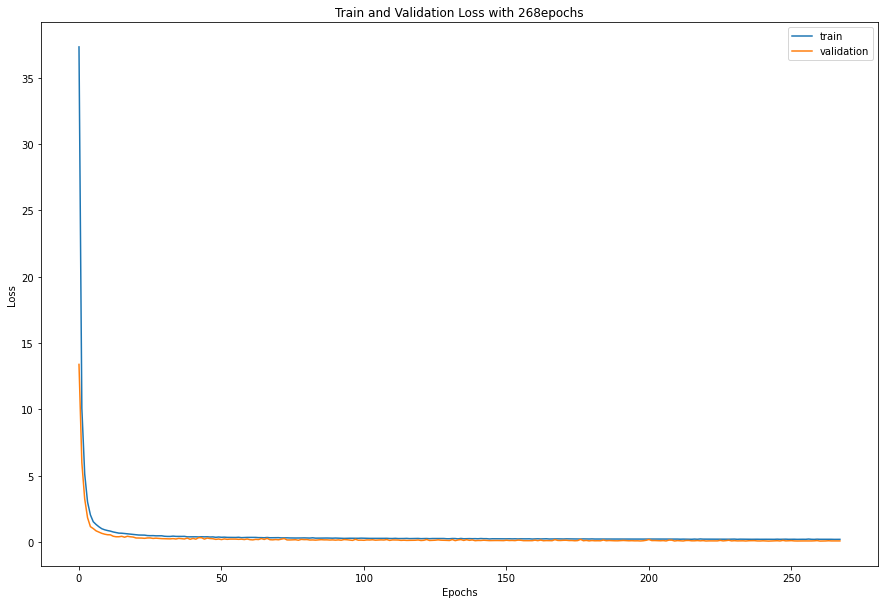

In [38]:
patience=25
# plotting training and validation history
plt.figure(figsize=(15,10))

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss') 


plt.title('Train and Validation Loss with '+str(len(history.history['val_loss']))+'epochs')
plt.legend()
 

plt.savefig('train_validation_after_'+str(len(history.history['val_loss'])-patience)+"_epochs.png")

print('The optimal number of epochs is '+str(len(history.history['val_loss'])-patience))

In [39]:
predictions.shape

(800, 82)

In [41]:
predict1=np.zeros(82) 
predict1=predictions[-3]
    
predict2=np.zeros((82))
predict2=predictions[-2]
    
predict3=np.zeros((82))
predict3=predictions[-1]

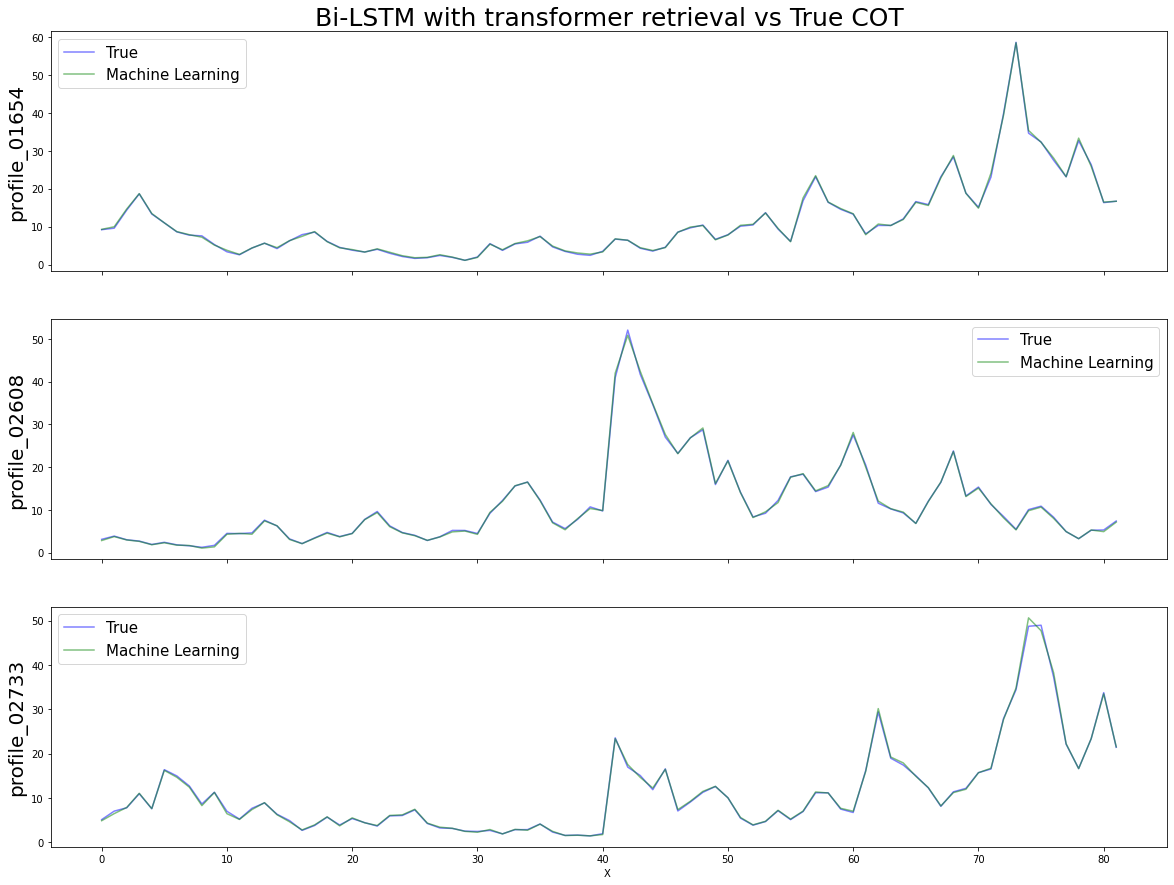

In [42]:
# plotting ---------------------------------------------------------------------------------------------------
fgnm = "plots/predict_Bi-LSTM with Transformer SZA=60 allVZAs_"+str(len(history.history['val_loss'])-patience)+'_epochs'
fig, axs = plt.subplots(nrows=3,ncols=1,sharex=True,figsize=(20,15))

# plots the last three test profiles

#plot the third last profile
ax = axs[0]
ax.set_title(r"Bi-LSTM with transformer retrieval vs True COT",fontsize=25)
ax.plot(range(82),test_label[800-3],alpha=0.5,color="blue") #ground truth
ax.plot(range(82),predict1,alpha=0.5,color="green") 
ax.legend(["True", "Machine Learning"],fontsize=15)
ax.set_ylabel(r"profile_01654",fontsize=20) 

#plot the second last profile
ax = axs[1]
ax.plot(range(82),test_label[800-2,:],alpha=0.5,color="blue")
ax.plot(range(82),predict2,alpha=0.5,color="green")
ax.legend(["True", "Machine Learning",'1D retrieval'],fontsize=15)
ax.set_ylabel(r"profile_02608",fontsize=20)  

# plot the last profile
ax = axs[2]
ax.plot(range(82),test_label[800-1,:].T,alpha=0.5,color="blue")
ax.plot(range(82),predict3.reshape(82,),alpha=0.5,color="green")
ax.legend(["True", "Machine Learning",'1D retrieval'],fontsize=15)
ax.set_ylabel(r"profile_02733",fontsize=20)  
ax.set_xlabel('X ')

plt.savefig(fgnm+".png",dpi=300,bbox_inches='tight')



# Plotting across predicted 82 COT values

In [46]:
std=[]
mean=[]

for k in range(82):
    tmp=[]
    for j in range(800):
        tmp.append(np.abs(predictions[j][k]-test_label[j][k]))
    std.append(np.std(tmp))
    mean.append(np.mean(tmp))

std=np.array(std)
mean=np.array(mean)

std1=np.mean(std)

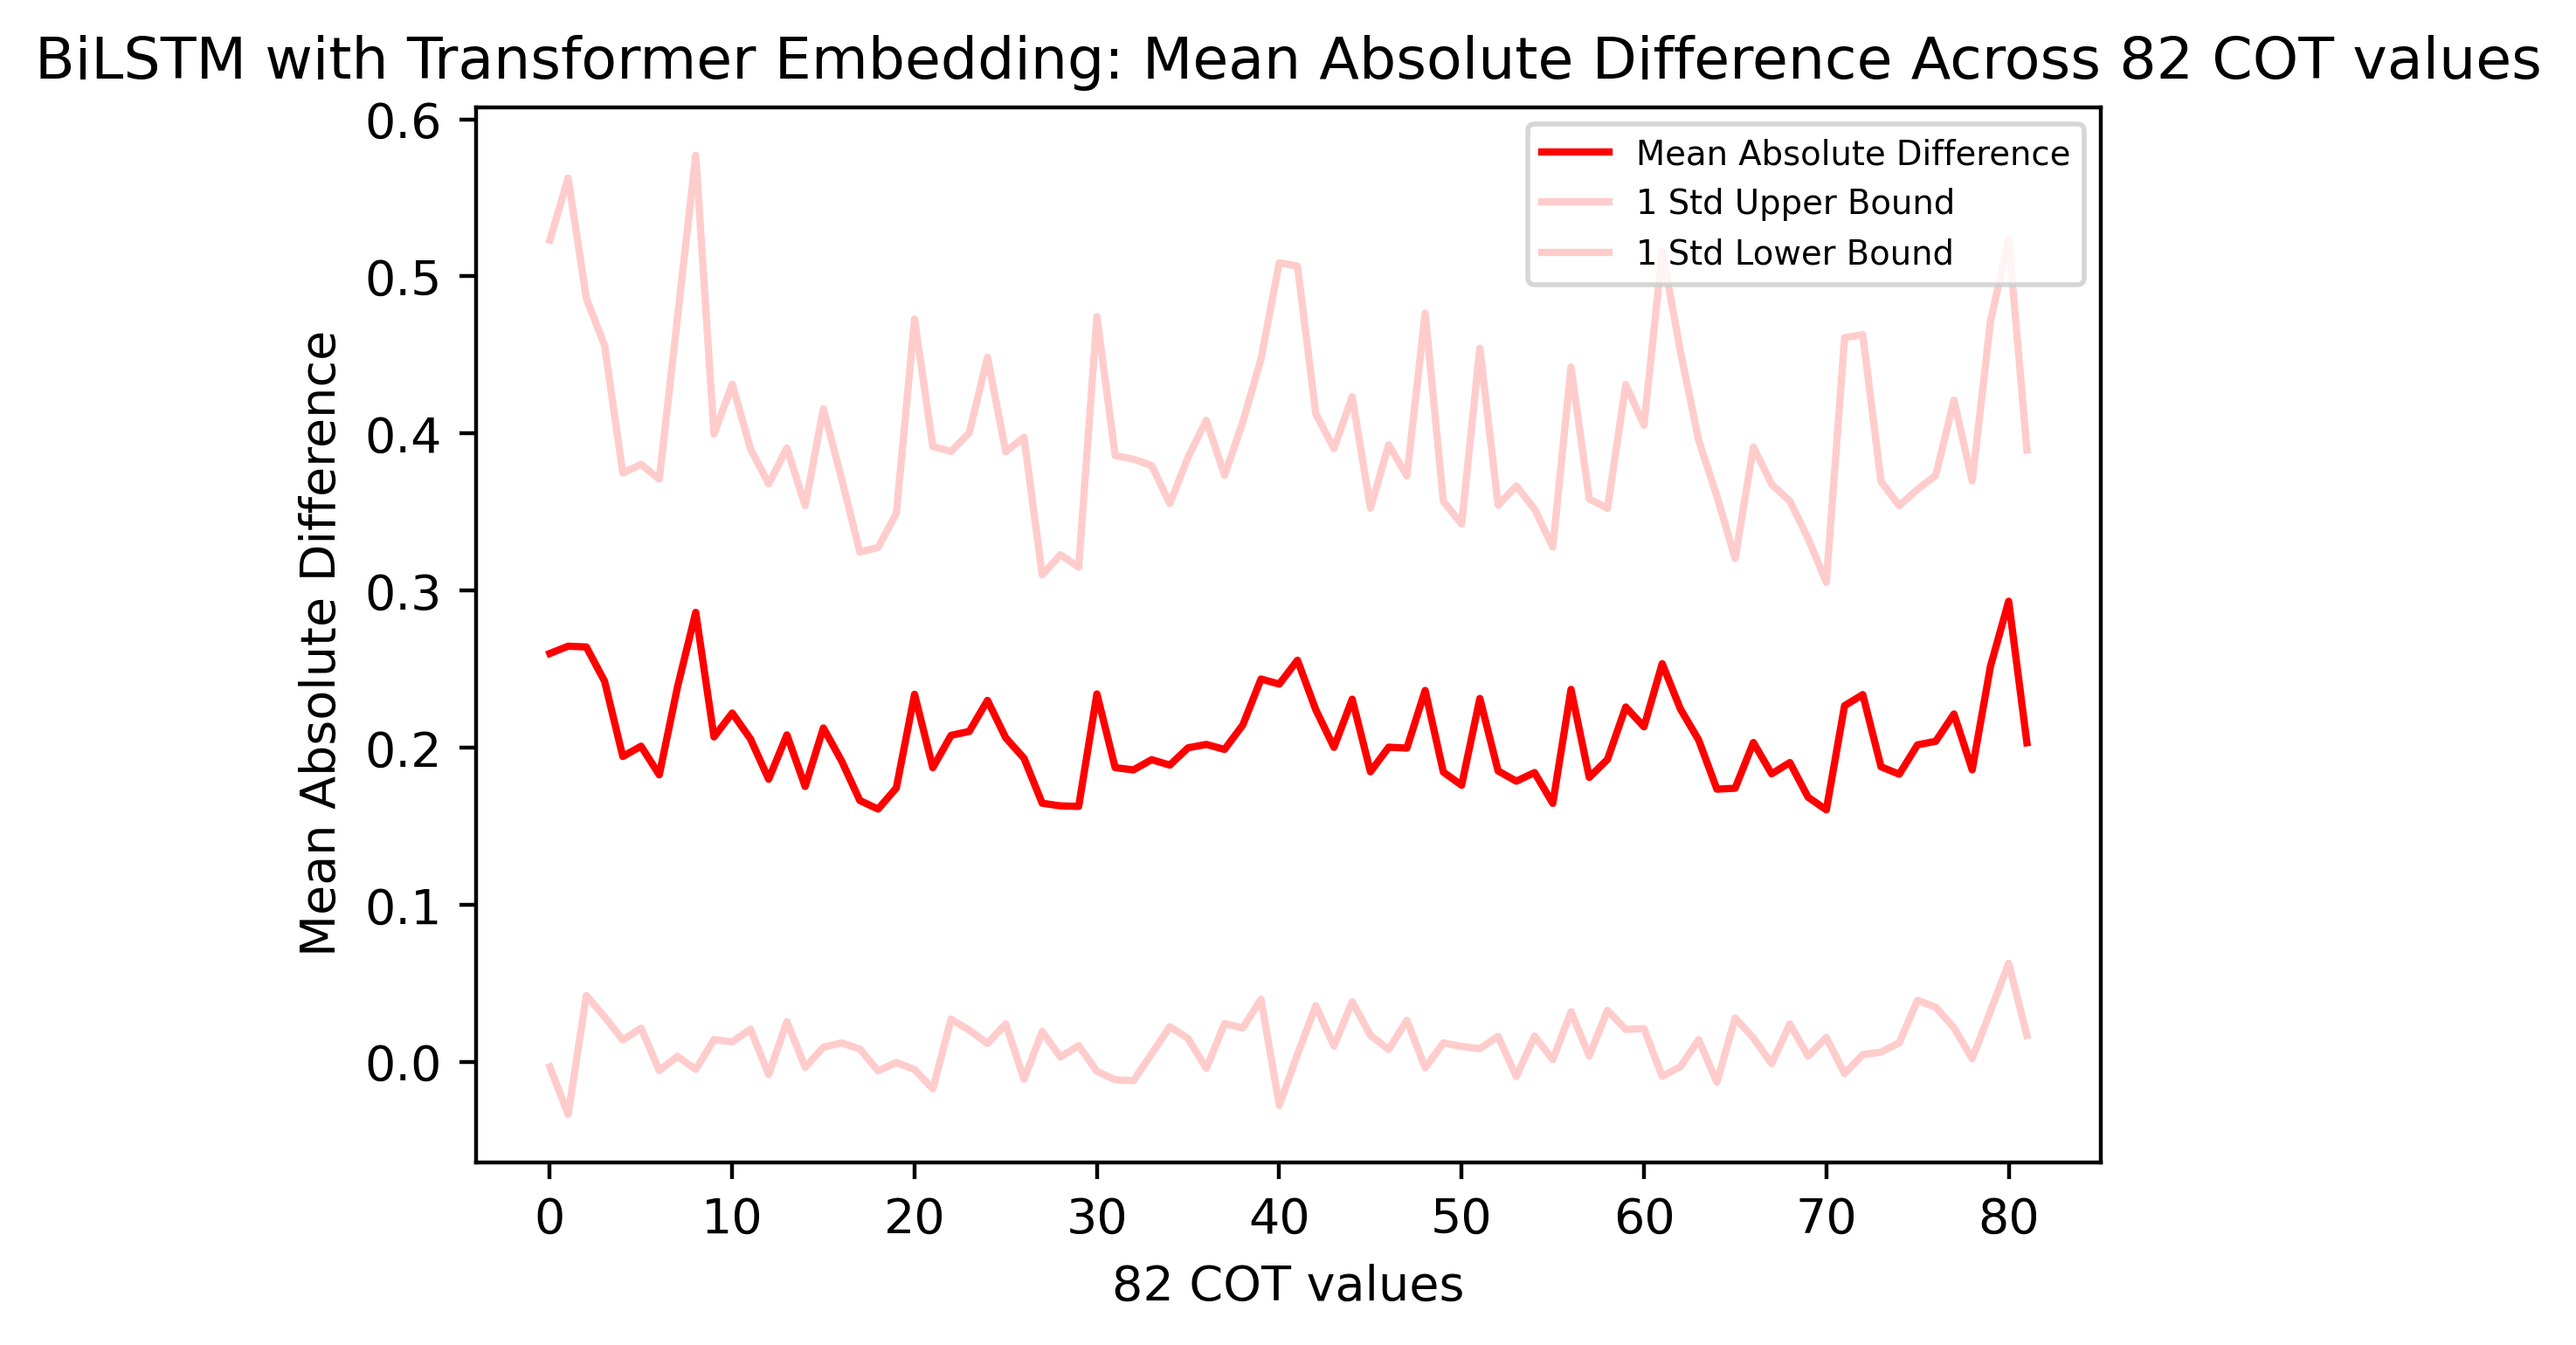

In [47]:
fig, ax = plt.subplots(dpi=400)
ax.plot(mean, '-r', label='Mean Absolute Difference')
ax.plot(mean+std, '-r', label='1 Std Upper Bound',alpha=0.2)
ax.plot(mean-std, '-r', label='1 Std Lower Bound',alpha=0.2)
ax.set_ylabel('Mean Absolute Difference ')  
ax.set_xlabel('82 COT values')

leg = ax.legend(loc=1,fontsize='x-small')
plt.title("BiLSTM with Transformer Embedding: Mean Absolute Difference Across 82 COT values")

plt.savefig('plots/BiLSTM-transformer_SZA=60_VZA=0_MeanAbsoluteDifferenceAcross82COTvalues.png',dpi=400)

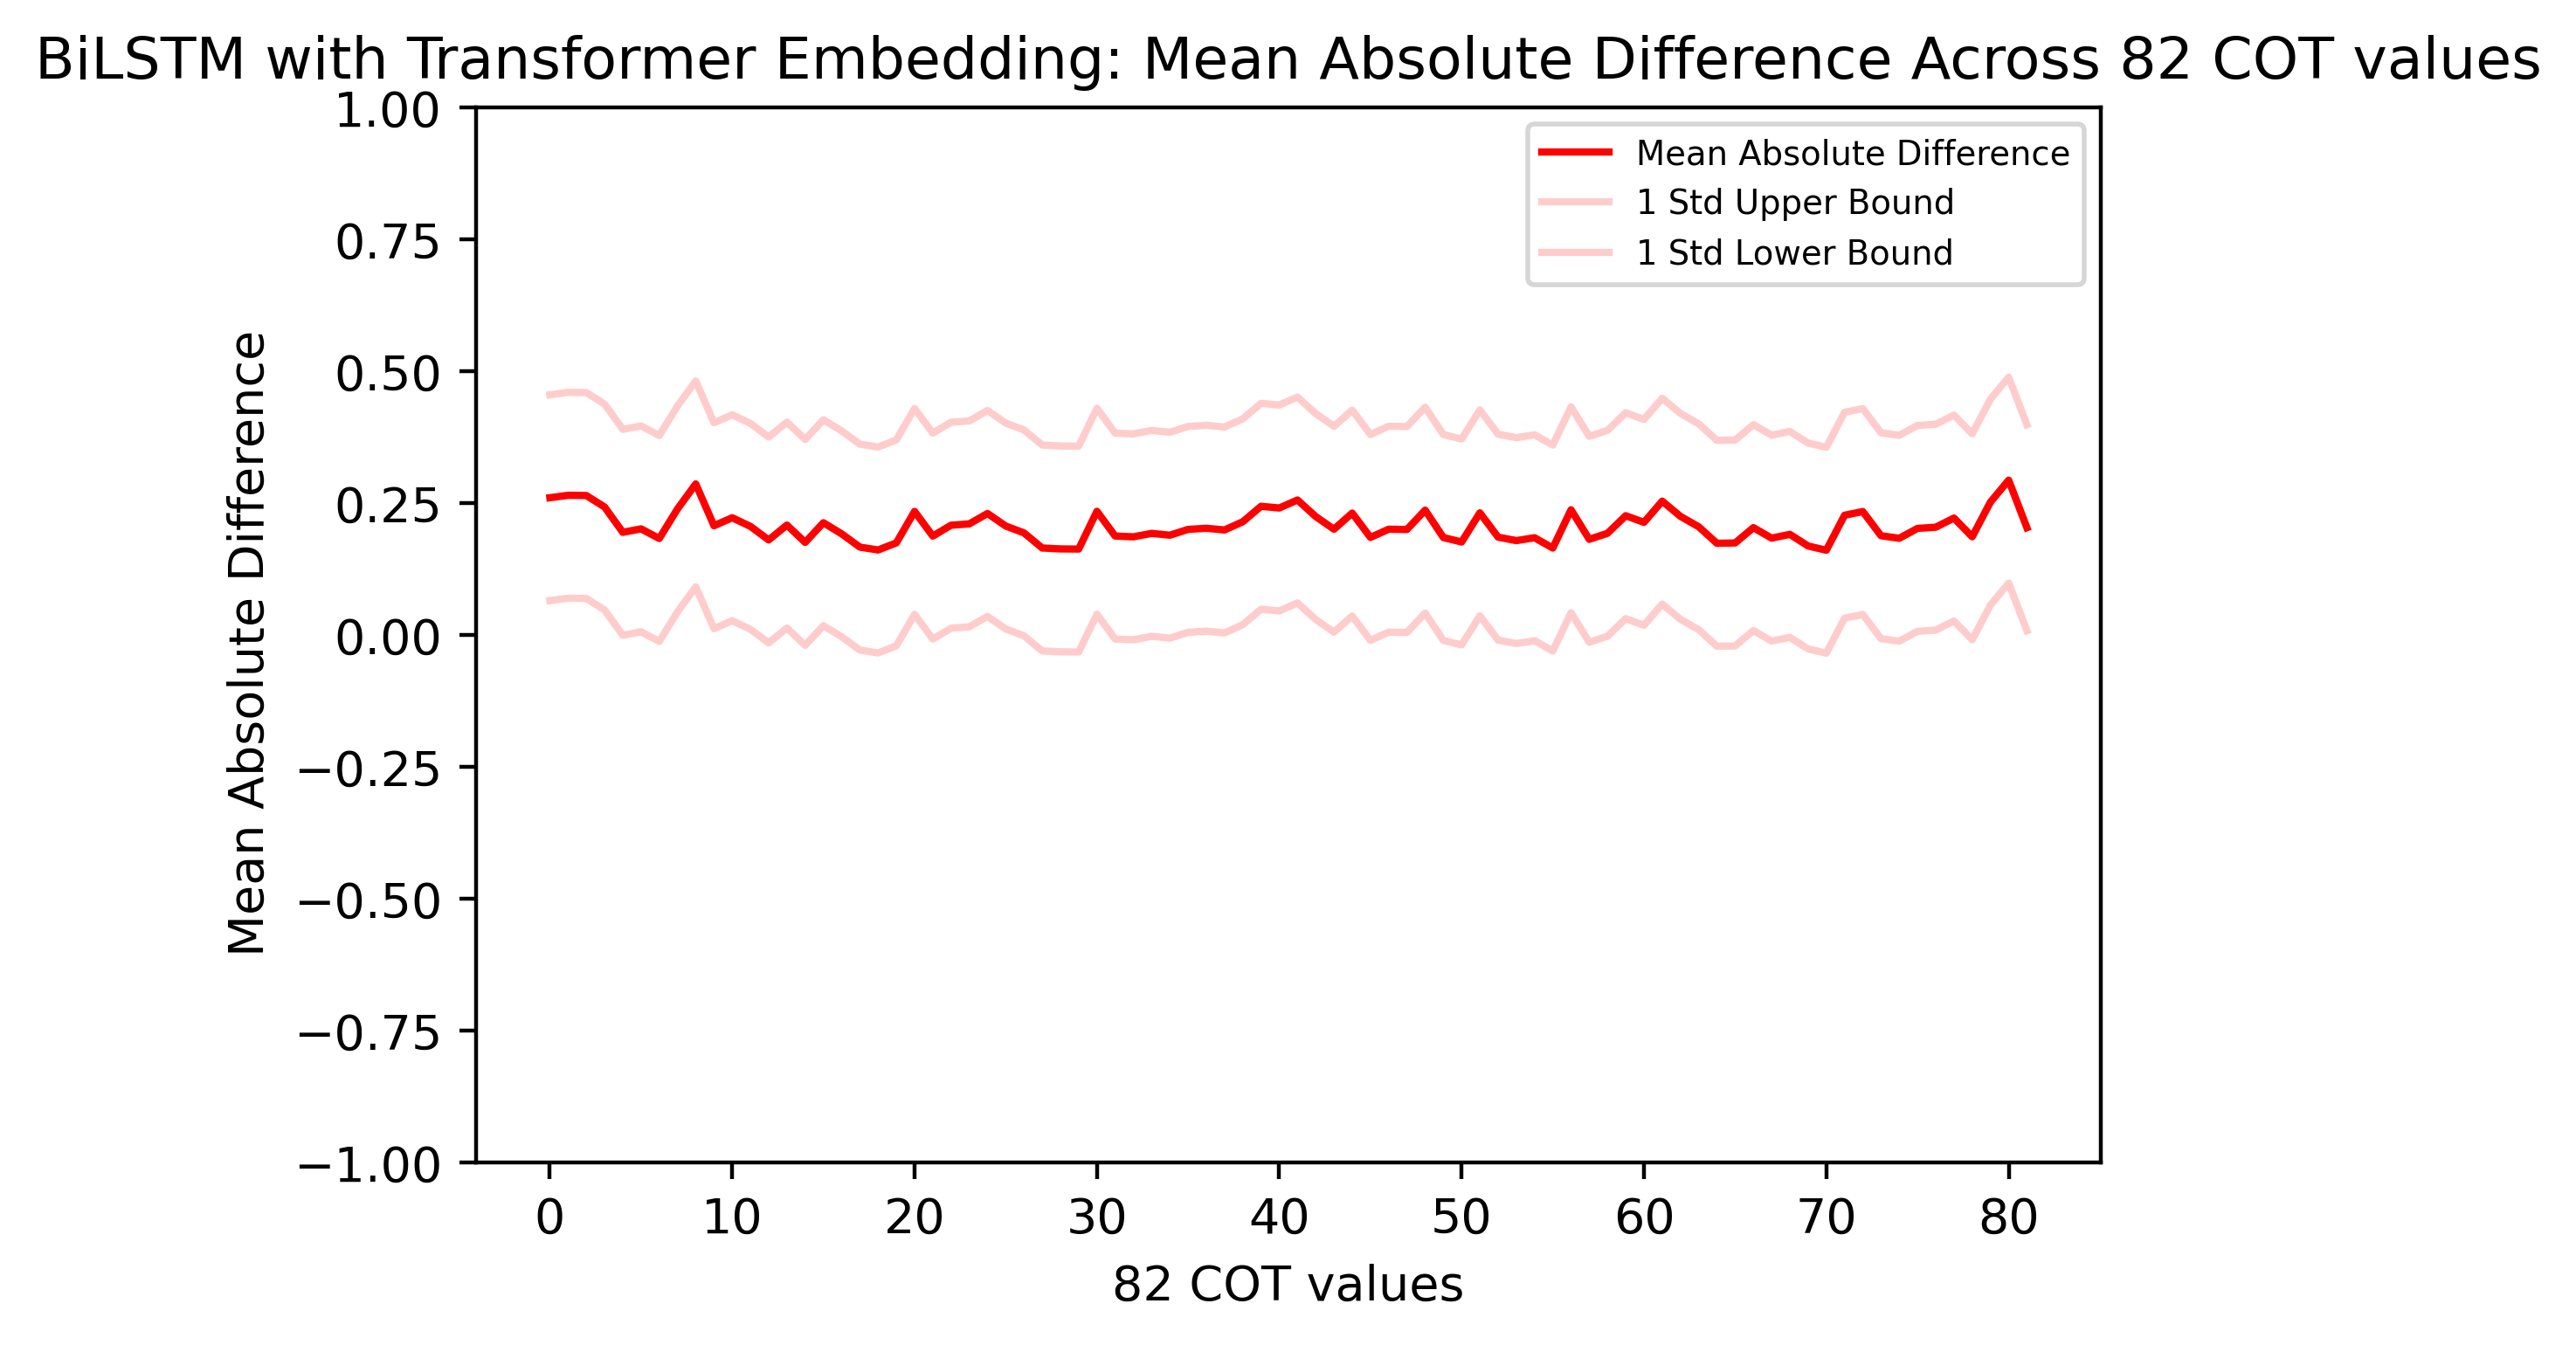

In [48]:
fig, ax = plt.subplots(dpi=400)
ax.plot(mean, '-r', label='Mean Absolute Difference')
ax.plot(mean+std1, '-r', label='1 Std Upper Bound',alpha=0.2)
ax.plot(mean-std1, '-r', label='1 Std Lower Bound',alpha=0.2)
ax.set_ylim((-1,1))

ax.set_ylabel('Mean Absolute Difference ')  
ax.set_xlabel('82 COT values')

leg = ax.legend(loc=1,fontsize='x-small')
plt.title("BiLSTM with Transformer Embedding: Mean Absolute Difference Across 82 COT values")

plt.savefig('plots/BiLSTM-transformer_SZA=60_allVZA_MeanAbsoluteDifferenceAcross82COTvalues.png',dpi=400)